In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
import covidcast
from datetime import date

In [5]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [6]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [7]:
data

,geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
0,al,2020-01-22,0.000000,0.183999,655.805922,0.086965,0.151171
1,al,2020-01-23,0.000000,0.171479,636.370230,0.103856,0.161668
2,al,2020-01-24,0.000000,0.169182,596.711830,0.104405,0.174012
3,al,2020-01-25,0.000000,0.172661,687.538565,0.083919,0.149298
4,al,2020-01-26,0.000000,0.193669,699.710495,0.087651,0.152943
...,...,...,...,...,...,...,...
9066,wv,2020-07-28,0.672611,0.273833,646.344539,0.039517,0.062896
9067,wv,2020-07-29,1.642459,0.270546,637.137487,0.042846,0.068807
9068,wv,2020-07-30,1.000000,0.266332,606.638365,0.051520,0.079922
9069,wv,2020-07-31,4.000000,0.246038,599.132159,0.041380,0.067567


In [8]:
iv=[5]

In [9]:
Y_raw = np.array(data[data.geo_value == 'pa'].deaths)
A_raw = np.array(data[data.geo_value == 'pa'].iloc[:,iv])

In [10]:
Y_raw.shape, A_raw.shape

((193,), (193, 1))

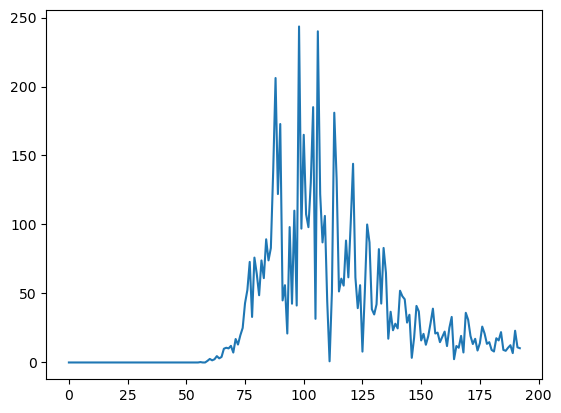

In [11]:
plt.plot(Y_raw)

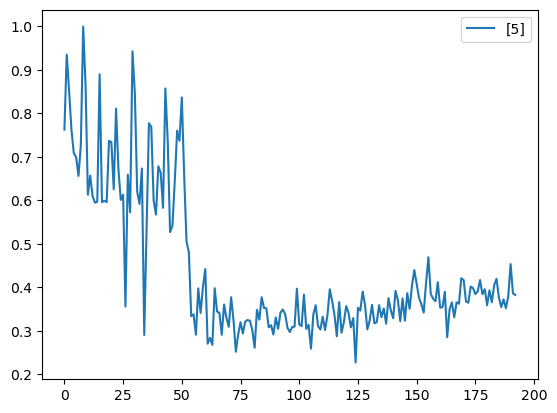

In [66]:
plt.plot(A_raw/np.max(A_raw, 0), label=iv)
plt.legend()

# 2. EDA

In [13]:
POI = np.sum(np.cumsum(Y_raw) < 10)
Y_data = np.maximum(np.round(Y_raw[POI:]), 0).astype(int)

In [14]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

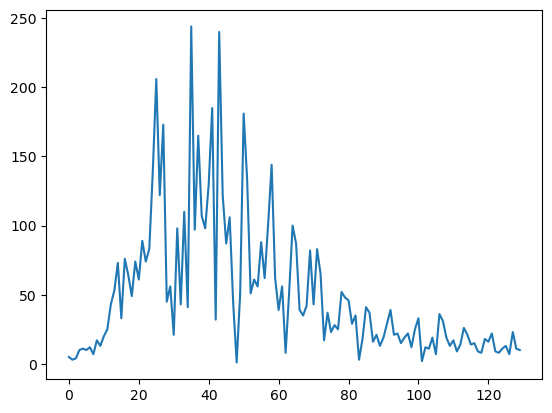

In [15]:
plt.plot(Y_data)

In [16]:
GPi = np.load('data/GPi.npz')

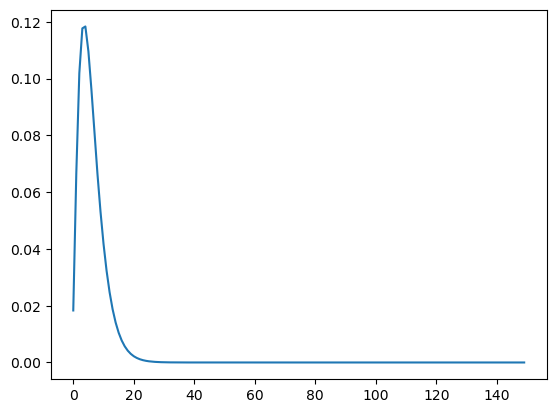

In [17]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

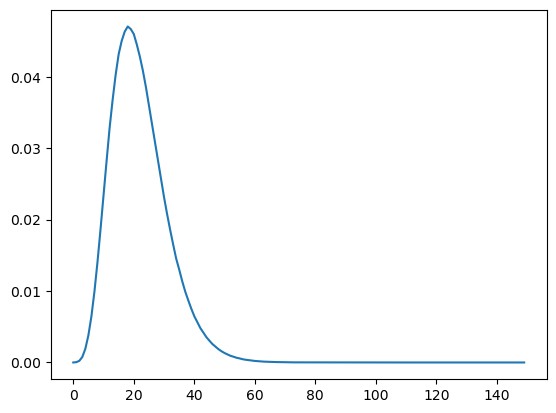

In [18]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [19]:
# A
d = len(iv)+1
A = np.zeros([T+T0, d])

In [21]:
A[:,0] = np.full(T+T0, 1)
A[:,1:] = A_raw[POI-T0:,:]/np.max(A_raw[:,:], 0)

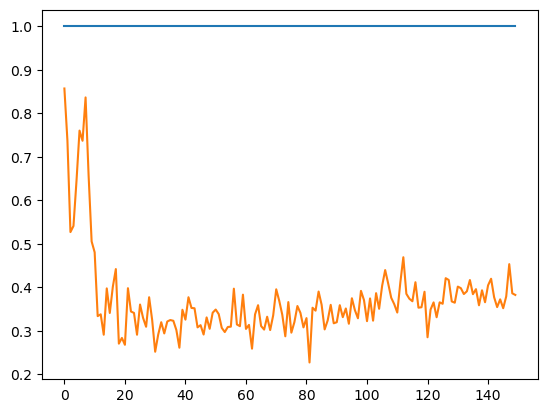

In [22]:
plt.plot(A)

# 3. fit by EM algorithm

In [23]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [24]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [25]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [26]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/10000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = np.abs(rhat + ss * dth[0])
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [27]:
rmle = 2.5
mmle_0 = 30
bmle = np.zeros(A.shape[-1])

In [28]:
%%notify
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=10000, step_size=1)

Before EM, ll: -4166.359564
1-th iteration finished, ll: -2219.134676, lapse: 0.018sec.
2-th iteration finished, ll: -1503.080233, lapse: 0.011sec.
3-th iteration finished, ll: -1370.351915, lapse: 0.008sec.
4-th iteration finished, ll: -1226.629459, lapse: 0.006sec.
5-th iteration finished, ll: -1059.896825, lapse: 0.011sec.
6-th iteration finished, ll: -868.955236, lapse: 0.006sec.
7-th iteration finished, ll: -1748.134253, lapse: 0.012sec.
8-th iteration finished, ll: -1027.344842, lapse: 0.007sec.
9-th iteration finished, ll: -931.057671, lapse: 0.005sec.
10-th iteration finished, ll: -1305.538670, lapse: 0.005sec.
11-th iteration finished, ll: -1059.560428, lapse: 0.008sec.
12-th iteration finished, ll: -986.744907, lapse: 0.010sec.
13-th iteration finished, ll: -883.968953, lapse: 0.005sec.
14-th iteration finished, ll: -808.168773, lapse: 0.012sec.
15-th iteration finished, ll: -764.884598, lapse: 0.011sec.
16-th iteration finished, ll: -752.966992, lapse: 0.005sec.
17-th iterat

154-th iteration finished, ll: -624.029038, lapse: 0.006sec.
155-th iteration finished, ll: -623.989305, lapse: 0.013sec.
156-th iteration finished, ll: -623.949944, lapse: 0.018sec.
157-th iteration finished, ll: -623.910951, lapse: 0.009sec.
158-th iteration finished, ll: -623.872319, lapse: 0.005sec.
159-th iteration finished, ll: -623.834043, lapse: 0.008sec.
160-th iteration finished, ll: -623.796117, lapse: 0.009sec.
161-th iteration finished, ll: -623.758534, lapse: 0.006sec.
162-th iteration finished, ll: -623.721291, lapse: 0.008sec.
163-th iteration finished, ll: -623.684381, lapse: 0.007sec.
164-th iteration finished, ll: -623.647799, lapse: 0.005sec.
165-th iteration finished, ll: -623.611541, lapse: 0.008sec.
166-th iteration finished, ll: -623.575601, lapse: 0.007sec.
167-th iteration finished, ll: -623.539974, lapse: 0.005sec.
168-th iteration finished, ll: -623.504656, lapse: 0.008sec.
169-th iteration finished, ll: -623.469642, lapse: 0.008sec.
170-th iteration finishe

304-th iteration finished, ll: -620.413757, lapse: 0.009sec.
305-th iteration finished, ll: -620.398667, lapse: 0.018sec.
306-th iteration finished, ll: -620.383645, lapse: 0.007sec.
307-th iteration finished, ll: -620.368693, lapse: 0.007sec.
308-th iteration finished, ll: -620.353808, lapse: 0.005sec.
309-th iteration finished, ll: -620.338990, lapse: 0.011sec.
310-th iteration finished, ll: -620.324240, lapse: 0.006sec.
311-th iteration finished, ll: -620.309556, lapse: 0.005sec.
312-th iteration finished, ll: -620.294938, lapse: 0.005sec.
313-th iteration finished, ll: -620.280384, lapse: 0.005sec.
314-th iteration finished, ll: -620.265896, lapse: 0.009sec.
315-th iteration finished, ll: -620.251472, lapse: 0.006sec.
316-th iteration finished, ll: -620.237112, lapse: 0.005sec.
317-th iteration finished, ll: -620.222815, lapse: 0.007sec.
318-th iteration finished, ll: -620.208581, lapse: 0.007sec.
319-th iteration finished, ll: -620.194410, lapse: 0.005sec.
320-th iteration finishe

446-th iteration finished, ll: -618.777218, lapse: 0.006sec.
447-th iteration finished, ll: -618.768347, lapse: 0.022sec.
448-th iteration finished, ll: -618.759503, lapse: 0.015sec.
449-th iteration finished, ll: -618.750687, lapse: 0.005sec.
450-th iteration finished, ll: -618.741897, lapse: 0.009sec.
451-th iteration finished, ll: -618.733135, lapse: 0.006sec.
452-th iteration finished, ll: -618.724399, lapse: 0.008sec.
453-th iteration finished, ll: -618.715689, lapse: 0.010sec.
454-th iteration finished, ll: -618.707006, lapse: 0.008sec.
455-th iteration finished, ll: -618.698350, lapse: 0.005sec.
456-th iteration finished, ll: -618.689719, lapse: 0.005sec.
457-th iteration finished, ll: -618.681115, lapse: 0.010sec.
458-th iteration finished, ll: -618.672537, lapse: 0.005sec.
459-th iteration finished, ll: -618.663984, lapse: 0.006sec.
460-th iteration finished, ll: -618.655457, lapse: 0.010sec.
461-th iteration finished, ll: -618.646955, lapse: 0.005sec.
462-th iteration finishe

592-th iteration finished, ll: -617.712599, lapse: 0.010sec.
593-th iteration finished, ll: -617.706584, lapse: 0.010sec.
594-th iteration finished, ll: -617.700583, lapse: 0.014sec.
595-th iteration finished, ll: -617.694596, lapse: 0.005sec.
596-th iteration finished, ll: -617.688622, lapse: 0.009sec.
597-th iteration finished, ll: -617.682662, lapse: 0.008sec.
598-th iteration finished, ll: -617.676716, lapse: 0.006sec.
599-th iteration finished, ll: -617.670783, lapse: 0.010sec.
600-th iteration finished, ll: -617.664864, lapse: 0.006sec.
601-th iteration finished, ll: -617.658959, lapse: 0.005sec.
602-th iteration finished, ll: -617.653067, lapse: 0.012sec.
603-th iteration finished, ll: -617.647188, lapse: 0.005sec.
604-th iteration finished, ll: -617.641322, lapse: 0.005sec.
605-th iteration finished, ll: -617.635470, lapse: 0.009sec.
606-th iteration finished, ll: -617.629631, lapse: 0.006sec.
607-th iteration finished, ll: -617.623805, lapse: 0.005sec.
608-th iteration finishe

738-th iteration finished, ll: -616.957677, lapse: 0.005sec.
739-th iteration finished, ll: -616.953225, lapse: 0.010sec.
740-th iteration finished, ll: -616.948781, lapse: 0.009sec.
741-th iteration finished, ll: -616.944345, lapse: 0.013sec.
742-th iteration finished, ll: -616.939917, lapse: 0.011sec.
743-th iteration finished, ll: -616.935498, lapse: 0.011sec.
744-th iteration finished, ll: -616.931086, lapse: 0.005sec.
745-th iteration finished, ll: -616.926683, lapse: 0.008sec.
746-th iteration finished, ll: -616.922288, lapse: 0.007sec.
747-th iteration finished, ll: -616.917901, lapse: 0.005sec.
748-th iteration finished, ll: -616.913521, lapse: 0.006sec.
749-th iteration finished, ll: -616.909150, lapse: 0.005sec.
750-th iteration finished, ll: -616.904787, lapse: 0.009sec.
751-th iteration finished, ll: -616.900431, lapse: 0.007sec.
752-th iteration finished, ll: -616.896084, lapse: 0.005sec.
753-th iteration finished, ll: -616.891744, lapse: 0.010sec.
754-th iteration finishe

873-th iteration finished, ll: -616.421681, lapse: 0.008sec.
874-th iteration finished, ll: -616.418139, lapse: 0.014sec.
875-th iteration finished, ll: -616.414602, lapse: 0.006sec.
876-th iteration finished, ll: -616.411071, lapse: 0.013sec.
877-th iteration finished, ll: -616.407545, lapse: 0.007sec.
878-th iteration finished, ll: -616.404025, lapse: 0.009sec.
879-th iteration finished, ll: -616.400510, lapse: 0.017sec.
880-th iteration finished, ll: -616.397001, lapse: 0.008sec.
881-th iteration finished, ll: -616.393497, lapse: 0.006sec.
882-th iteration finished, ll: -616.389999, lapse: 0.014sec.
883-th iteration finished, ll: -616.386506, lapse: 0.006sec.
884-th iteration finished, ll: -616.383018, lapse: 0.011sec.
885-th iteration finished, ll: -616.379536, lapse: 0.017sec.
886-th iteration finished, ll: -616.376059, lapse: 0.006sec.
887-th iteration finished, ll: -616.372587, lapse: 0.012sec.
888-th iteration finished, ll: -616.369121, lapse: 0.005sec.
889-th iteration finishe

1017-th iteration finished, ll: -615.961946, lapse: 0.009sec.
1018-th iteration finished, ll: -615.959067, lapse: 0.017sec.
1019-th iteration finished, ll: -615.956193, lapse: 0.006sec.
1020-th iteration finished, ll: -615.953322, lapse: 0.008sec.
1021-th iteration finished, ll: -615.950455, lapse: 0.007sec.
1022-th iteration finished, ll: -615.947592, lapse: 0.013sec.
1023-th iteration finished, ll: -615.944733, lapse: 0.007sec.
1024-th iteration finished, ll: -615.941878, lapse: 0.006sec.
1025-th iteration finished, ll: -615.939026, lapse: 0.013sec.
1026-th iteration finished, ll: -615.936178, lapse: 0.008sec.
1027-th iteration finished, ll: -615.933334, lapse: 0.015sec.
1028-th iteration finished, ll: -615.930493, lapse: 0.006sec.
1029-th iteration finished, ll: -615.927657, lapse: 0.008sec.
1030-th iteration finished, ll: -615.924824, lapse: 0.005sec.
1031-th iteration finished, ll: -615.921995, lapse: 0.009sec.
1032-th iteration finished, ll: -615.919169, lapse: 0.007sec.
1033-th 

1169-th iteration finished, ll: -615.563959, lapse: 0.011sec.
1170-th iteration finished, ll: -615.561577, lapse: 0.010sec.
1171-th iteration finished, ll: -615.559197, lapse: 0.006sec.
1172-th iteration finished, ll: -615.556821, lapse: 0.014sec.
1173-th iteration finished, ll: -615.554447, lapse: 0.008sec.
1174-th iteration finished, ll: -615.552075, lapse: 0.005sec.
1175-th iteration finished, ll: -615.549707, lapse: 0.006sec.
1176-th iteration finished, ll: -615.547341, lapse: 0.011sec.
1177-th iteration finished, ll: -615.544978, lapse: 0.005sec.
1178-th iteration finished, ll: -615.542618, lapse: 0.010sec.
1179-th iteration finished, ll: -615.540261, lapse: 0.007sec.
1180-th iteration finished, ll: -615.537906, lapse: 0.005sec.
1181-th iteration finished, ll: -615.535554, lapse: 0.006sec.
1182-th iteration finished, ll: -615.533204, lapse: 0.006sec.
1183-th iteration finished, ll: -615.530858, lapse: 0.005sec.
1184-th iteration finished, ll: -615.528514, lapse: 0.007sec.
1185-th 

1319-th iteration finished, ll: -615.234749, lapse: 0.009sec.
1320-th iteration finished, ll: -615.232727, lapse: 0.018sec.
1321-th iteration finished, ll: -615.230708, lapse: 0.012sec.
1322-th iteration finished, ll: -615.228690, lapse: 0.008sec.
1323-th iteration finished, ll: -615.226674, lapse: 0.005sec.
1324-th iteration finished, ll: -615.224660, lapse: 0.009sec.
1325-th iteration finished, ll: -615.222649, lapse: 0.011sec.
1326-th iteration finished, ll: -615.220639, lapse: 0.007sec.
1327-th iteration finished, ll: -615.218632, lapse: 0.005sec.
1328-th iteration finished, ll: -615.216627, lapse: 0.008sec.
1329-th iteration finished, ll: -615.214623, lapse: 0.007sec.
1330-th iteration finished, ll: -615.212622, lapse: 0.005sec.
1331-th iteration finished, ll: -615.210623, lapse: 0.007sec.
1332-th iteration finished, ll: -615.208625, lapse: 0.010sec.
1333-th iteration finished, ll: -615.206630, lapse: 0.005sec.
1334-th iteration finished, ll: -615.204637, lapse: 0.005sec.
1335-th 

1452-th iteration finished, ll: -614.982783, lapse: 0.009sec.
1453-th iteration finished, ll: -614.981009, lapse: 0.015sec.
1454-th iteration finished, ll: -614.979236, lapse: 0.011sec.
1455-th iteration finished, ll: -614.977465, lapse: 0.010sec.
1456-th iteration finished, ll: -614.975695, lapse: 0.007sec.
1457-th iteration finished, ll: -614.973927, lapse: 0.005sec.
1458-th iteration finished, ll: -614.972161, lapse: 0.006sec.
1459-th iteration finished, ll: -614.970397, lapse: 0.009sec.
1460-th iteration finished, ll: -614.968634, lapse: 0.005sec.
1461-th iteration finished, ll: -614.966872, lapse: 0.007sec.
1462-th iteration finished, ll: -614.965113, lapse: 0.009sec.
1463-th iteration finished, ll: -614.963355, lapse: 0.006sec.
1464-th iteration finished, ll: -614.961598, lapse: 0.005sec.
1465-th iteration finished, ll: -614.959843, lapse: 0.010sec.
1466-th iteration finished, ll: -614.958090, lapse: 0.005sec.
1467-th iteration finished, ll: -614.956339, lapse: 0.005sec.
1468-th 

1605-th iteration finished, ll: -614.729138, lapse: 0.011sec.
1606-th iteration finished, ll: -614.727589, lapse: 0.029sec.
1607-th iteration finished, ll: -614.726042, lapse: 0.008sec.
1608-th iteration finished, ll: -614.724496, lapse: 0.012sec.
1609-th iteration finished, ll: -614.722952, lapse: 0.011sec.
1610-th iteration finished, ll: -614.721408, lapse: 0.006sec.
1611-th iteration finished, ll: -614.719866, lapse: 0.014sec.
1612-th iteration finished, ll: -614.718326, lapse: 0.006sec.
1613-th iteration finished, ll: -614.716786, lapse: 0.005sec.
1614-th iteration finished, ll: -614.715248, lapse: 0.008sec.
1615-th iteration finished, ll: -614.713712, lapse: 0.016sec.
1616-th iteration finished, ll: -614.712176, lapse: 0.005sec.
1617-th iteration finished, ll: -614.710642, lapse: 0.013sec.
1618-th iteration finished, ll: -614.709109, lapse: 0.006sec.
1619-th iteration finished, ll: -614.707577, lapse: 0.005sec.
1620-th iteration finished, ll: -614.706047, lapse: 0.014sec.
1621-th 

1747-th iteration finished, ll: -614.521542, lapse: 0.010sec.
1748-th iteration finished, ll: -614.520163, lapse: 0.017sec.
1749-th iteration finished, ll: -614.518784, lapse: 0.006sec.
1750-th iteration finished, ll: -614.517406, lapse: 0.013sec.
1751-th iteration finished, ll: -614.516030, lapse: 0.007sec.
1752-th iteration finished, ll: -614.514654, lapse: 0.012sec.
1753-th iteration finished, ll: -614.513280, lapse: 0.005sec.
1754-th iteration finished, ll: -614.511906, lapse: 0.006sec.
1755-th iteration finished, ll: -614.510534, lapse: 0.014sec.
1756-th iteration finished, ll: -614.509163, lapse: 0.005sec.
1757-th iteration finished, ll: -614.507793, lapse: 0.011sec.
1758-th iteration finished, ll: -614.506424, lapse: 0.006sec.
1759-th iteration finished, ll: -614.505056, lapse: 0.006sec.
1760-th iteration finished, ll: -614.503689, lapse: 0.011sec.
1761-th iteration finished, ll: -614.502323, lapse: 0.006sec.
1762-th iteration finished, ll: -614.500958, lapse: 0.006sec.
1763-th 

1891-th iteration finished, ll: -614.333262, lapse: 0.017sec.
1892-th iteration finished, ll: -614.332023, lapse: 0.016sec.
1893-th iteration finished, ll: -614.330785, lapse: 0.006sec.
1894-th iteration finished, ll: -614.329548, lapse: 0.008sec.
1895-th iteration finished, ll: -614.328312, lapse: 0.007sec.
1896-th iteration finished, ll: -614.327077, lapse: 0.005sec.
1897-th iteration finished, ll: -614.325843, lapse: 0.007sec.
1898-th iteration finished, ll: -614.324610, lapse: 0.013sec.
1899-th iteration finished, ll: -614.323378, lapse: 0.006sec.
1900-th iteration finished, ll: -614.322146, lapse: 0.005sec.
1901-th iteration finished, ll: -614.320915, lapse: 0.011sec.
1902-th iteration finished, ll: -614.319686, lapse: 0.009sec.
1903-th iteration finished, ll: -614.318457, lapse: 0.010sec.
1904-th iteration finished, ll: -614.317229, lapse: 0.006sec.
1905-th iteration finished, ll: -614.316002, lapse: 0.005sec.
1906-th iteration finished, ll: -614.314775, lapse: 0.010sec.
1907-th 

2035-th iteration finished, ll: -614.163580, lapse: 0.011sec.
2036-th iteration finished, ll: -614.162459, lapse: 0.020sec.
2037-th iteration finished, ll: -614.161339, lapse: 0.009sec.
2038-th iteration finished, ll: -614.160220, lapse: 0.016sec.
2039-th iteration finished, ll: -614.159102, lapse: 0.007sec.
2040-th iteration finished, ll: -614.157984, lapse: 0.011sec.
2041-th iteration finished, ll: -614.156867, lapse: 0.015sec.
2042-th iteration finished, ll: -614.155751, lapse: 0.011sec.
2043-th iteration finished, ll: -614.154636, lapse: 0.007sec.
2044-th iteration finished, ll: -614.153521, lapse: 0.010sec.
2045-th iteration finished, ll: -614.152407, lapse: 0.008sec.
2046-th iteration finished, ll: -614.151294, lapse: 0.006sec.
2047-th iteration finished, ll: -614.150182, lapse: 0.012sec.
2048-th iteration finished, ll: -614.149070, lapse: 0.005sec.
2049-th iteration finished, ll: -614.147959, lapse: 0.008sec.
2050-th iteration finished, ll: -614.146849, lapse: 0.011sec.
2051-th 

2171-th iteration finished, ll: -614.017734, lapse: 0.012sec.
2172-th iteration finished, ll: -614.016709, lapse: 0.012sec.
2173-th iteration finished, ll: -614.015683, lapse: 0.007sec.
2174-th iteration finished, ll: -614.014659, lapse: 0.007sec.
2175-th iteration finished, ll: -614.013635, lapse: 0.005sec.
2176-th iteration finished, ll: -614.012612, lapse: 0.009sec.
2177-th iteration finished, ll: -614.011589, lapse: 0.007sec.
2178-th iteration finished, ll: -614.010567, lapse: 0.005sec.
2179-th iteration finished, ll: -614.009546, lapse: 0.007sec.
2180-th iteration finished, ll: -614.008525, lapse: 0.006sec.
2181-th iteration finished, ll: -614.007505, lapse: 0.013sec.
2182-th iteration finished, ll: -614.006485, lapse: 0.006sec.
2183-th iteration finished, ll: -614.005467, lapse: 0.005sec.
2184-th iteration finished, ll: -614.004448, lapse: 0.009sec.
2185-th iteration finished, ll: -614.003431, lapse: 0.006sec.
2186-th iteration finished, ll: -614.002414, lapse: 0.009sec.
2187-th 

2332-th iteration finished, ll: -613.860437, lapse: 0.005sec.
2333-th iteration finished, ll: -613.859507, lapse: 0.012sec.
2334-th iteration finished, ll: -613.858577, lapse: 0.005sec.
2335-th iteration finished, ll: -613.857648, lapse: 0.005sec.
2336-th iteration finished, ll: -613.856720, lapse: 0.009sec.
2337-th iteration finished, ll: -613.855792, lapse: 0.006sec.
2338-th iteration finished, ll: -613.854864, lapse: 0.006sec.
2339-th iteration finished, ll: -613.853937, lapse: 0.010sec.
2340-th iteration finished, ll: -613.853011, lapse: 0.005sec.
2341-th iteration finished, ll: -613.852085, lapse: 0.005sec.
2342-th iteration finished, ll: -613.851160, lapse: 0.009sec.
2343-th iteration finished, ll: -613.850235, lapse: 0.006sec.
2344-th iteration finished, ll: -613.849311, lapse: 0.005sec.
2345-th iteration finished, ll: -613.848387, lapse: 0.009sec.
2346-th iteration finished, ll: -613.847464, lapse: 0.005sec.
2347-th iteration finished, ll: -613.846541, lapse: 0.005sec.
2348-th 

2466-th iteration finished, ll: -613.740446, lapse: 0.060sec.
2467-th iteration finished, ll: -613.739584, lapse: 0.064sec.
2468-th iteration finished, ll: -613.738723, lapse: 0.010sec.
2469-th iteration finished, ll: -613.737862, lapse: 0.006sec.
2470-th iteration finished, ll: -613.737002, lapse: 0.012sec.
2471-th iteration finished, ll: -613.736142, lapse: 0.005sec.
2472-th iteration finished, ll: -613.735283, lapse: 0.005sec.
2473-th iteration finished, ll: -613.734424, lapse: 0.010sec.
2474-th iteration finished, ll: -613.733566, lapse: 0.012sec.
2475-th iteration finished, ll: -613.732708, lapse: 0.014sec.
2476-th iteration finished, ll: -613.731851, lapse: 0.010sec.
2477-th iteration finished, ll: -613.730994, lapse: 0.007sec.
2478-th iteration finished, ll: -613.730137, lapse: 0.008sec.
2479-th iteration finished, ll: -613.729281, lapse: 0.010sec.
2480-th iteration finished, ll: -613.728426, lapse: 0.011sec.
2481-th iteration finished, ll: -613.727571, lapse: 0.019sec.
2482-th 

2602-th iteration finished, ll: -613.627475, lapse: 0.018sec.
2603-th iteration finished, ll: -613.626675, lapse: 0.009sec.
2604-th iteration finished, ll: -613.625874, lapse: 0.011sec.
2605-th iteration finished, ll: -613.625075, lapse: 0.010sec.
2606-th iteration finished, ll: -613.624276, lapse: 0.010sec.
2607-th iteration finished, ll: -613.623477, lapse: 0.006sec.
2608-th iteration finished, ll: -613.622678, lapse: 0.012sec.
2609-th iteration finished, ll: -613.621880, lapse: 0.008sec.
2610-th iteration finished, ll: -613.621083, lapse: 0.007sec.
2611-th iteration finished, ll: -613.620286, lapse: 0.006sec.
2612-th iteration finished, ll: -613.619489, lapse: 0.006sec.
2613-th iteration finished, ll: -613.618693, lapse: 0.008sec.
2614-th iteration finished, ll: -613.617897, lapse: 0.010sec.
2615-th iteration finished, ll: -613.617101, lapse: 0.005sec.
2616-th iteration finished, ll: -613.616306, lapse: 0.008sec.
2617-th iteration finished, ll: -613.615512, lapse: 0.011sec.
2618-th 

2736-th iteration finished, ll: -613.523828, lapse: 0.225sec.
2737-th iteration finished, ll: -613.523081, lapse: 0.028sec.
2738-th iteration finished, ll: -613.522334, lapse: 0.101sec.
2739-th iteration finished, ll: -613.521588, lapse: 0.010sec.
2740-th iteration finished, ll: -613.520842, lapse: 0.012sec.
2741-th iteration finished, ll: -613.520096, lapse: 0.013sec.
2742-th iteration finished, ll: -613.519351, lapse: 0.010sec.
2743-th iteration finished, ll: -613.518606, lapse: 0.013sec.
2744-th iteration finished, ll: -613.517862, lapse: 0.010sec.
2745-th iteration finished, ll: -613.517118, lapse: 0.014sec.
2746-th iteration finished, ll: -613.516374, lapse: 0.013sec.
2747-th iteration finished, ll: -613.515630, lapse: 0.007sec.
2748-th iteration finished, ll: -613.514887, lapse: 0.005sec.
2749-th iteration finished, ll: -613.514145, lapse: 0.009sec.
2750-th iteration finished, ll: -613.513402, lapse: 0.011sec.
2751-th iteration finished, ll: -613.512661, lapse: 0.008sec.
2752-th 

2885-th iteration finished, ll: -613.416479, lapse: 0.005sec.
2886-th iteration finished, ll: -613.415784, lapse: 0.010sec.
2887-th iteration finished, ll: -613.415090, lapse: 0.005sec.
2888-th iteration finished, ll: -613.414396, lapse: 0.005sec.
2889-th iteration finished, ll: -613.413703, lapse: 0.010sec.
2890-th iteration finished, ll: -613.413010, lapse: 0.005sec.
2891-th iteration finished, ll: -613.412317, lapse: 0.005sec.
2892-th iteration finished, ll: -613.411624, lapse: 0.010sec.
2893-th iteration finished, ll: -613.410932, lapse: 0.006sec.
2894-th iteration finished, ll: -613.410240, lapse: 0.005sec.
2895-th iteration finished, ll: -613.409548, lapse: 0.009sec.
2896-th iteration finished, ll: -613.408857, lapse: 0.006sec.
2897-th iteration finished, ll: -613.408166, lapse: 0.005sec.
2898-th iteration finished, ll: -613.407476, lapse: 0.009sec.
2899-th iteration finished, ll: -613.406785, lapse: 0.006sec.
2900-th iteration finished, ll: -613.406096, lapse: 0.005sec.
2901-th 

3019-th iteration finished, ll: -613.326262, lapse: 0.007sec.
3020-th iteration finished, ll: -613.325610, lapse: 0.010sec.
3021-th iteration finished, ll: -613.324958, lapse: 0.010sec.
3022-th iteration finished, ll: -613.324306, lapse: 0.009sec.
3023-th iteration finished, ll: -613.323655, lapse: 0.005sec.
3024-th iteration finished, ll: -613.323003, lapse: 0.005sec.
3025-th iteration finished, ll: -613.322352, lapse: 0.017sec.
3026-th iteration finished, ll: -613.321702, lapse: 0.005sec.
3027-th iteration finished, ll: -613.321051, lapse: 0.015sec.
3028-th iteration finished, ll: -613.320401, lapse: 0.005sec.
3029-th iteration finished, ll: -613.319752, lapse: 0.013sec.
3030-th iteration finished, ll: -613.319102, lapse: 0.009sec.
3031-th iteration finished, ll: -613.318453, lapse: 0.011sec.
3032-th iteration finished, ll: -613.317804, lapse: 0.009sec.
3033-th iteration finished, ll: -613.317156, lapse: 0.014sec.
3034-th iteration finished, ll: -613.316507, lapse: 0.008sec.
3035-th 

3157-th iteration finished, ll: -613.238952, lapse: 0.021sec.
3158-th iteration finished, ll: -613.238338, lapse: 0.009sec.
3159-th iteration finished, ll: -613.237725, lapse: 0.010sec.
3160-th iteration finished, ll: -613.237112, lapse: 0.005sec.
3161-th iteration finished, ll: -613.236500, lapse: 0.010sec.
3162-th iteration finished, ll: -613.235888, lapse: 0.008sec.
3163-th iteration finished, ll: -613.235275, lapse: 0.032sec.
3164-th iteration finished, ll: -613.234664, lapse: 0.030sec.
3165-th iteration finished, ll: -613.234052, lapse: 0.011sec.
3166-th iteration finished, ll: -613.233441, lapse: 0.008sec.
3167-th iteration finished, ll: -613.232830, lapse: 0.005sec.
3168-th iteration finished, ll: -613.232219, lapse: 0.008sec.
3169-th iteration finished, ll: -613.231609, lapse: 0.006sec.
3170-th iteration finished, ll: -613.230999, lapse: 0.008sec.
3171-th iteration finished, ll: -613.230389, lapse: 0.010sec.
3172-th iteration finished, ll: -613.229779, lapse: 0.007sec.
3173-th 

3296-th iteration finished, ll: -613.156184, lapse: 0.007sec.
3297-th iteration finished, ll: -613.155606, lapse: 0.019sec.
3298-th iteration finished, ll: -613.155028, lapse: 0.011sec.
3299-th iteration finished, ll: -613.154451, lapse: 0.006sec.
3300-th iteration finished, ll: -613.153873, lapse: 0.005sec.
3301-th iteration finished, ll: -613.153297, lapse: 0.006sec.
3302-th iteration finished, ll: -613.152720, lapse: 0.015sec.
3303-th iteration finished, ll: -613.152143, lapse: 0.013sec.
3304-th iteration finished, ll: -613.151567, lapse: 0.035sec.
3305-th iteration finished, ll: -613.150991, lapse: 0.012sec.
3306-th iteration finished, ll: -613.150416, lapse: 0.013sec.
3307-th iteration finished, ll: -613.149840, lapse: 0.006sec.
3308-th iteration finished, ll: -613.149265, lapse: 0.014sec.
3309-th iteration finished, ll: -613.148690, lapse: 0.009sec.
3310-th iteration finished, ll: -613.148115, lapse: 0.006sec.
3311-th iteration finished, ll: -613.147541, lapse: 0.005sec.
3312-th 

3438-th iteration finished, ll: -613.076474, lapse: 0.013sec.
3439-th iteration finished, ll: -613.075929, lapse: 0.011sec.
3440-th iteration finished, ll: -613.075385, lapse: 0.007sec.
3441-th iteration finished, ll: -613.074840, lapse: 0.007sec.
3442-th iteration finished, ll: -613.074295, lapse: 0.009sec.
3443-th iteration finished, ll: -613.073751, lapse: 0.006sec.
3444-th iteration finished, ll: -613.073207, lapse: 0.007sec.
3445-th iteration finished, ll: -613.072663, lapse: 0.009sec.
3446-th iteration finished, ll: -613.072120, lapse: 0.005sec.
3447-th iteration finished, ll: -613.071577, lapse: 0.006sec.
3448-th iteration finished, ll: -613.071033, lapse: 0.010sec.
3449-th iteration finished, ll: -613.070491, lapse: 0.005sec.
3450-th iteration finished, ll: -613.069948, lapse: 0.005sec.
3451-th iteration finished, ll: -613.069405, lapse: 0.010sec.
3452-th iteration finished, ll: -613.068863, lapse: 0.005sec.
3453-th iteration finished, ll: -613.068321, lapse: 0.006sec.
3454-th 

3578-th iteration finished, ll: -613.002235, lapse: 0.020sec.
3579-th iteration finished, ll: -613.001720, lapse: 0.022sec.
3580-th iteration finished, ll: -613.001204, lapse: 0.005sec.
3581-th iteration finished, ll: -613.000689, lapse: 0.015sec.
3582-th iteration finished, ll: -613.000174, lapse: 0.007sec.
3583-th iteration finished, ll: -612.999659, lapse: 0.016sec.
3584-th iteration finished, ll: -612.999144, lapse: 0.012sec.
3585-th iteration finished, ll: -612.998629, lapse: 0.012sec.
3586-th iteration finished, ll: -612.998115, lapse: 0.008sec.
3587-th iteration finished, ll: -612.997601, lapse: 0.005sec.
3588-th iteration finished, ll: -612.997087, lapse: 0.005sec.
3589-th iteration finished, ll: -612.996573, lapse: 0.009sec.
3590-th iteration finished, ll: -612.996060, lapse: 0.009sec.
3591-th iteration finished, ll: -612.995546, lapse: 0.005sec.
3592-th iteration finished, ll: -612.995033, lapse: 0.005sec.
3593-th iteration finished, ll: -612.994520, lapse: 0.009sec.
3594-th 

3714-th iteration finished, ll: -612.933882, lapse: 0.010sec.
3715-th iteration finished, ll: -612.933392, lapse: 0.010sec.
3716-th iteration finished, ll: -612.932903, lapse: 0.008sec.
3717-th iteration finished, ll: -612.932414, lapse: 0.011sec.
3718-th iteration finished, ll: -612.931924, lapse: 0.005sec.
3719-th iteration finished, ll: -612.931436, lapse: 0.007sec.
3720-th iteration finished, ll: -612.930947, lapse: 0.009sec.
3721-th iteration finished, ll: -612.930458, lapse: 0.005sec.
3722-th iteration finished, ll: -612.929970, lapse: 0.008sec.
3723-th iteration finished, ll: -612.929482, lapse: 0.008sec.
3724-th iteration finished, ll: -612.928994, lapse: 0.005sec.
3725-th iteration finished, ll: -612.928506, lapse: 0.006sec.
3726-th iteration finished, ll: -612.928018, lapse: 0.011sec.
3727-th iteration finished, ll: -612.927531, lapse: 0.005sec.
3728-th iteration finished, ll: -612.927043, lapse: 0.007sec.
3729-th iteration finished, ll: -612.926556, lapse: 0.010sec.
3730-th 

3855-th iteration finished, ll: -612.866598, lapse: 0.009sec.
3856-th iteration finished, ll: -612.866133, lapse: 0.013sec.
3857-th iteration finished, ll: -612.865668, lapse: 0.007sec.
3858-th iteration finished, ll: -612.865203, lapse: 0.009sec.
3859-th iteration finished, ll: -612.864739, lapse: 0.008sec.
3860-th iteration finished, ll: -612.864275, lapse: 0.008sec.
3861-th iteration finished, ll: -612.863811, lapse: 0.009sec.
3862-th iteration finished, ll: -612.863347, lapse: 0.005sec.
3863-th iteration finished, ll: -612.862883, lapse: 0.009sec.
3864-th iteration finished, ll: -612.862420, lapse: 0.008sec.
3865-th iteration finished, ll: -612.861956, lapse: 0.005sec.
3866-th iteration finished, ll: -612.861493, lapse: 0.009sec.
3867-th iteration finished, ll: -612.861030, lapse: 0.007sec.
3868-th iteration finished, ll: -612.860567, lapse: 0.006sec.
3869-th iteration finished, ll: -612.860104, lapse: 0.008sec.
3870-th iteration finished, ll: -612.859642, lapse: 0.008sec.
3871-th 

3989-th iteration finished, ll: -612.805758, lapse: 0.011sec.
3990-th iteration finished, ll: -612.805314, lapse: 0.010sec.
3991-th iteration finished, ll: -612.804871, lapse: 0.012sec.
3992-th iteration finished, ll: -612.804428, lapse: 0.008sec.
3993-th iteration finished, ll: -612.803986, lapse: 0.006sec.
3994-th iteration finished, ll: -612.803543, lapse: 0.008sec.
3995-th iteration finished, ll: -612.803100, lapse: 0.008sec.
3996-th iteration finished, ll: -612.802658, lapse: 0.005sec.
3997-th iteration finished, ll: -612.802216, lapse: 0.008sec.
3998-th iteration finished, ll: -612.801774, lapse: 0.009sec.
3999-th iteration finished, ll: -612.801332, lapse: 0.005sec.
4000-th iteration finished, ll: -612.800890, lapse: 0.011sec.
4001-th iteration finished, ll: -612.800449, lapse: 0.005sec.
4002-th iteration finished, ll: -612.800007, lapse: 0.005sec.
4003-th iteration finished, ll: -612.799566, lapse: 0.011sec.
4004-th iteration finished, ll: -612.799125, lapse: 0.005sec.
4005-th 

4134-th iteration finished, ll: -612.743057, lapse: 0.017sec.
4135-th iteration finished, ll: -612.742635, lapse: 0.013sec.
4136-th iteration finished, ll: -612.742214, lapse: 0.005sec.
4137-th iteration finished, ll: -612.741792, lapse: 0.008sec.
4138-th iteration finished, ll: -612.741371, lapse: 0.011sec.
4139-th iteration finished, ll: -612.740950, lapse: 0.006sec.
4140-th iteration finished, ll: -612.740529, lapse: 0.007sec.
4141-th iteration finished, ll: -612.740108, lapse: 0.008sec.
4142-th iteration finished, ll: -612.739687, lapse: 0.006sec.
4143-th iteration finished, ll: -612.739267, lapse: 0.008sec.
4144-th iteration finished, ll: -612.738846, lapse: 0.008sec.
4145-th iteration finished, ll: -612.738426, lapse: 0.005sec.
4146-th iteration finished, ll: -612.738006, lapse: 0.008sec.
4147-th iteration finished, ll: -612.737586, lapse: 0.009sec.
4148-th iteration finished, ll: -612.737166, lapse: 0.005sec.
4149-th iteration finished, ll: -612.736746, lapse: 0.009sec.
4150-th 

4274-th iteration finished, ll: -612.685370, lapse: 0.017sec.
4275-th iteration finished, ll: -612.684967, lapse: 0.012sec.
4276-th iteration finished, ll: -612.684565, lapse: 0.007sec.
4277-th iteration finished, ll: -612.684162, lapse: 0.006sec.
4278-th iteration finished, ll: -612.683760, lapse: 0.011sec.
4279-th iteration finished, ll: -612.683358, lapse: 0.005sec.
4280-th iteration finished, ll: -612.682956, lapse: 0.006sec.
4281-th iteration finished, ll: -612.682555, lapse: 0.009sec.
4282-th iteration finished, ll: -612.682153, lapse: 0.005sec.
4283-th iteration finished, ll: -612.681752, lapse: 0.010sec.
4284-th iteration finished, ll: -612.681350, lapse: 0.011sec.
4285-th iteration finished, ll: -612.680949, lapse: 0.008sec.
4286-th iteration finished, ll: -612.680548, lapse: 0.009sec.
4287-th iteration finished, ll: -612.680147, lapse: 0.010sec.
4288-th iteration finished, ll: -612.679746, lapse: 0.010sec.
4289-th iteration finished, ll: -612.679346, lapse: 0.005sec.
4290-th 

4428-th iteration finished, ll: -612.624894, lapse: 0.014sec.
4429-th iteration finished, ll: -612.624511, lapse: 0.011sec.
4430-th iteration finished, ll: -612.624128, lapse: 0.013sec.
4431-th iteration finished, ll: -612.623746, lapse: 0.005sec.
4432-th iteration finished, ll: -612.623363, lapse: 0.007sec.
4433-th iteration finished, ll: -612.622980, lapse: 0.009sec.
4434-th iteration finished, ll: -612.622598, lapse: 0.007sec.
4435-th iteration finished, ll: -612.622216, lapse: 0.007sec.
4436-th iteration finished, ll: -612.621834, lapse: 0.008sec.
4437-th iteration finished, ll: -612.621452, lapse: 0.008sec.
4438-th iteration finished, ll: -612.621070, lapse: 0.009sec.
4439-th iteration finished, ll: -612.620688, lapse: 0.006sec.
4440-th iteration finished, ll: -612.620306, lapse: 0.005sec.
4441-th iteration finished, ll: -612.619924, lapse: 0.011sec.
4442-th iteration finished, ll: -612.619543, lapse: 0.006sec.
4443-th iteration finished, ll: -612.619162, lapse: 0.006sec.
4444-th 

4571-th iteration finished, ll: -612.571324, lapse: 0.010sec.
4572-th iteration finished, ll: -612.570957, lapse: 0.011sec.
4573-th iteration finished, ll: -612.570591, lapse: 0.005sec.
4574-th iteration finished, ll: -612.570225, lapse: 0.006sec.
4575-th iteration finished, ll: -612.569859, lapse: 0.009sec.
4576-th iteration finished, ll: -612.569493, lapse: 0.010sec.
4577-th iteration finished, ll: -612.569128, lapse: 0.008sec.
4578-th iteration finished, ll: -612.568762, lapse: 0.007sec.
4579-th iteration finished, ll: -612.568396, lapse: 0.005sec.
4580-th iteration finished, ll: -612.568031, lapse: 0.008sec.
4581-th iteration finished, ll: -612.567666, lapse: 0.008sec.
4582-th iteration finished, ll: -612.567301, lapse: 0.005sec.
4583-th iteration finished, ll: -612.566935, lapse: 0.009sec.
4584-th iteration finished, ll: -612.566571, lapse: 0.007sec.
4585-th iteration finished, ll: -612.566206, lapse: 0.005sec.
4586-th iteration finished, ll: -612.565841, lapse: 0.008sec.
4587-th 

4708-th iteration finished, ll: -612.522165, lapse: 0.007sec.
4709-th iteration finished, ll: -612.521814, lapse: 0.011sec.
4710-th iteration finished, ll: -612.521463, lapse: 0.010sec.
4711-th iteration finished, ll: -612.521111, lapse: 0.005sec.
4712-th iteration finished, ll: -612.520760, lapse: 0.005sec.
4713-th iteration finished, ll: -612.520409, lapse: 0.010sec.
4714-th iteration finished, ll: -612.520058, lapse: 0.007sec.
4715-th iteration finished, ll: -612.519708, lapse: 0.005sec.
4716-th iteration finished, ll: -612.519357, lapse: 0.010sec.
4717-th iteration finished, ll: -612.519006, lapse: 0.006sec.
4718-th iteration finished, ll: -612.518656, lapse: 0.005sec.
4719-th iteration finished, ll: -612.518306, lapse: 0.008sec.
4720-th iteration finished, ll: -612.517955, lapse: 0.007sec.
4721-th iteration finished, ll: -612.517605, lapse: 0.005sec.
4722-th iteration finished, ll: -612.517255, lapse: 0.007sec.
4723-th iteration finished, ll: -612.516905, lapse: 0.009sec.
4724-th 

4849-th iteration finished, ll: -612.473631, lapse: 0.080sec.
4850-th iteration finished, ll: -612.473294, lapse: 0.010sec.
4851-th iteration finished, ll: -612.472957, lapse: 0.011sec.
4852-th iteration finished, ll: -612.472620, lapse: 0.007sec.
4853-th iteration finished, ll: -612.472283, lapse: 0.006sec.
4854-th iteration finished, ll: -612.471947, lapse: 0.008sec.
4855-th iteration finished, ll: -612.471610, lapse: 0.008sec.
4856-th iteration finished, ll: -612.471274, lapse: 0.009sec.
4857-th iteration finished, ll: -612.470937, lapse: 0.005sec.
4858-th iteration finished, ll: -612.470601, lapse: 0.008sec.
4859-th iteration finished, ll: -612.470265, lapse: 0.010sec.
4860-th iteration finished, ll: -612.469929, lapse: 0.010sec.
4861-th iteration finished, ll: -612.469593, lapse: 0.005sec.
4862-th iteration finished, ll: -612.469257, lapse: 0.010sec.
4863-th iteration finished, ll: -612.468921, lapse: 0.006sec.
4864-th iteration finished, ll: -612.468585, lapse: 0.006sec.
4865-th 

5000-th iteration finished, ll: -612.423815, lapse: 0.010sec.
5001-th iteration finished, ll: -612.423492, lapse: 0.011sec.
5002-th iteration finished, ll: -612.423169, lapse: 0.010sec.
5003-th iteration finished, ll: -612.422846, lapse: 0.010sec.
5004-th iteration finished, ll: -612.422524, lapse: 0.009sec.
5005-th iteration finished, ll: -612.422201, lapse: 0.005sec.
5006-th iteration finished, ll: -612.421879, lapse: 0.006sec.
5007-th iteration finished, ll: -612.421557, lapse: 0.010sec.
5008-th iteration finished, ll: -612.421235, lapse: 0.006sec.
5009-th iteration finished, ll: -612.420913, lapse: 0.006sec.
5010-th iteration finished, ll: -612.420591, lapse: 0.010sec.
5011-th iteration finished, ll: -612.420269, lapse: 0.005sec.
5012-th iteration finished, ll: -612.419947, lapse: 0.008sec.
5013-th iteration finished, ll: -612.419625, lapse: 0.006sec.
5014-th iteration finished, ll: -612.419304, lapse: 0.005sec.
5015-th iteration finished, ll: -612.418982, lapse: 0.010sec.
5016-th 

5147-th iteration finished, ll: -612.377318, lapse: 0.011sec.
5148-th iteration finished, ll: -612.377009, lapse: 0.010sec.
5149-th iteration finished, ll: -612.376699, lapse: 0.014sec.
5150-th iteration finished, ll: -612.376389, lapse: 0.006sec.
5151-th iteration finished, ll: -612.376080, lapse: 0.005sec.
5152-th iteration finished, ll: -612.375770, lapse: 0.010sec.
5153-th iteration finished, ll: -612.375461, lapse: 0.006sec.
5154-th iteration finished, ll: -612.375151, lapse: 0.005sec.
5155-th iteration finished, ll: -612.374842, lapse: 0.010sec.
5156-th iteration finished, ll: -612.374533, lapse: 0.006sec.
5157-th iteration finished, ll: -612.374224, lapse: 0.005sec.
5158-th iteration finished, ll: -612.373915, lapse: 0.010sec.
5159-th iteration finished, ll: -612.373606, lapse: 0.005sec.
5160-th iteration finished, ll: -612.373297, lapse: 0.006sec.
5161-th iteration finished, ll: -612.372988, lapse: 0.009sec.
5162-th iteration finished, ll: -612.372680, lapse: 0.008sec.
5163-th 

5283-th iteration finished, ll: -612.335945, lapse: 0.011sec.
5284-th iteration finished, ll: -612.335647, lapse: 0.013sec.
5285-th iteration finished, ll: -612.335348, lapse: 0.006sec.
5286-th iteration finished, ll: -612.335050, lapse: 0.005sec.
5287-th iteration finished, ll: -612.334751, lapse: 0.010sec.
5288-th iteration finished, ll: -612.334453, lapse: 0.006sec.
5289-th iteration finished, ll: -612.334155, lapse: 0.005sec.
5290-th iteration finished, ll: -612.333857, lapse: 0.010sec.
5291-th iteration finished, ll: -612.333558, lapse: 0.006sec.
5292-th iteration finished, ll: -612.333261, lapse: 0.010sec.
5293-th iteration finished, ll: -612.332963, lapse: 0.005sec.
5294-th iteration finished, ll: -612.332665, lapse: 0.011sec.
5295-th iteration finished, ll: -612.332367, lapse: 0.006sec.
5296-th iteration finished, ll: -612.332069, lapse: 0.005sec.
5297-th iteration finished, ll: -612.331772, lapse: 0.011sec.
5298-th iteration finished, ll: -612.331474, lapse: 0.005sec.
5299-th 

5422-th iteration finished, ll: -612.295191, lapse: 0.007sec.
5423-th iteration finished, ll: -612.294903, lapse: 0.010sec.
5424-th iteration finished, ll: -612.294615, lapse: 0.017sec.
5425-th iteration finished, ll: -612.294328, lapse: 0.010sec.
5426-th iteration finished, ll: -612.294040, lapse: 0.005sec.
5427-th iteration finished, ll: -612.293753, lapse: 0.007sec.
5428-th iteration finished, ll: -612.293465, lapse: 0.010sec.
5429-th iteration finished, ll: -612.293178, lapse: 0.009sec.
5430-th iteration finished, ll: -612.292891, lapse: 0.005sec.
5431-th iteration finished, ll: -612.292603, lapse: 0.005sec.
5432-th iteration finished, ll: -612.292316, lapse: 0.011sec.
5433-th iteration finished, ll: -612.292029, lapse: 0.007sec.
5434-th iteration finished, ll: -612.291742, lapse: 0.009sec.
5435-th iteration finished, ll: -612.291455, lapse: 0.006sec.
5436-th iteration finished, ll: -612.291169, lapse: 0.008sec.
5437-th iteration finished, ll: -612.290882, lapse: 0.008sec.
5438-th 

5562-th iteration finished, ll: -612.255617, lapse: 0.012sec.
5563-th iteration finished, ll: -612.255339, lapse: 0.011sec.
5564-th iteration finished, ll: -612.255062, lapse: 0.006sec.
5565-th iteration finished, ll: -612.254784, lapse: 0.006sec.
5566-th iteration finished, ll: -612.254507, lapse: 0.009sec.
5567-th iteration finished, ll: -612.254229, lapse: 0.005sec.
5568-th iteration finished, ll: -612.253952, lapse: 0.006sec.
5569-th iteration finished, ll: -612.253675, lapse: 0.010sec.
5570-th iteration finished, ll: -612.253398, lapse: 0.005sec.
5571-th iteration finished, ll: -612.253121, lapse: 0.006sec.
5572-th iteration finished, ll: -612.252844, lapse: 0.010sec.
5573-th iteration finished, ll: -612.252567, lapse: 0.006sec.
5574-th iteration finished, ll: -612.252290, lapse: 0.006sec.
5575-th iteration finished, ll: -612.252014, lapse: 0.010sec.
5576-th iteration finished, ll: -612.251737, lapse: 0.007sec.
5577-th iteration finished, ll: -612.251460, lapse: 0.007sec.
5578-th 

5697-th iteration finished, ll: -612.218775, lapse: 0.011sec.
5698-th iteration finished, ll: -612.218507, lapse: 0.015sec.
5699-th iteration finished, ll: -612.218238, lapse: 0.005sec.
5700-th iteration finished, ll: -612.217970, lapse: 0.006sec.
5701-th iteration finished, ll: -612.217702, lapse: 0.007sec.
5702-th iteration finished, ll: -612.217434, lapse: 0.005sec.
5703-th iteration finished, ll: -612.217166, lapse: 0.010sec.
5704-th iteration finished, ll: -612.216899, lapse: 0.006sec.
5705-th iteration finished, ll: -612.216631, lapse: 0.006sec.
5706-th iteration finished, ll: -612.216363, lapse: 0.010sec.
5707-th iteration finished, ll: -612.216095, lapse: 0.006sec.
5708-th iteration finished, ll: -612.215828, lapse: 0.006sec.
5709-th iteration finished, ll: -612.215560, lapse: 0.007sec.
5710-th iteration finished, ll: -612.215293, lapse: 0.005sec.
5711-th iteration finished, ll: -612.215025, lapse: 0.010sec.
5712-th iteration finished, ll: -612.214758, lapse: 0.006sec.
5713-th 

5843-th iteration finished, ll: -612.180306, lapse: 0.007sec.
5844-th iteration finished, ll: -612.180047, lapse: 0.012sec.
5845-th iteration finished, ll: -612.179789, lapse: 0.006sec.
5846-th iteration finished, ll: -612.179530, lapse: 0.005sec.
5847-th iteration finished, ll: -612.179271, lapse: 0.010sec.
5848-th iteration finished, ll: -612.179013, lapse: 0.006sec.
5849-th iteration finished, ll: -612.178755, lapse: 0.006sec.
5850-th iteration finished, ll: -612.178496, lapse: 0.010sec.
5851-th iteration finished, ll: -612.178238, lapse: 0.007sec.
5852-th iteration finished, ll: -612.177980, lapse: 0.006sec.
5853-th iteration finished, ll: -612.177721, lapse: 0.010sec.
5854-th iteration finished, ll: -612.177463, lapse: 0.005sec.
5855-th iteration finished, ll: -612.177205, lapse: 0.005sec.
5856-th iteration finished, ll: -612.176947, lapse: 0.010sec.
5857-th iteration finished, ll: -612.176689, lapse: 0.005sec.
5858-th iteration finished, ll: -612.176432, lapse: 0.005sec.
5859-th 

5977-th iteration finished, ll: -612.146187, lapse: 0.008sec.
5978-th iteration finished, ll: -612.145937, lapse: 0.031sec.
5979-th iteration finished, ll: -612.145686, lapse: 0.005sec.
5980-th iteration finished, ll: -612.145436, lapse: 0.025sec.
5981-th iteration finished, ll: -612.145186, lapse: 0.008sec.
5982-th iteration finished, ll: -612.144935, lapse: 0.006sec.
5983-th iteration finished, ll: -612.144685, lapse: 0.006sec.
5984-th iteration finished, ll: -612.144435, lapse: 0.005sec.
5985-th iteration finished, ll: -612.144185, lapse: 0.007sec.
5986-th iteration finished, ll: -612.143935, lapse: 0.005sec.
5987-th iteration finished, ll: -612.143685, lapse: 0.006sec.
5988-th iteration finished, ll: -612.143435, lapse: 0.005sec.
5989-th iteration finished, ll: -612.143185, lapse: 0.007sec.
5990-th iteration finished, ll: -612.142935, lapse: 0.005sec.
5991-th iteration finished, ll: -612.142686, lapse: 0.010sec.
5992-th iteration finished, ll: -612.142436, lapse: 0.008sec.
5993-th 

6122-th iteration finished, ll: -612.110478, lapse: 0.013sec.
6123-th iteration finished, ll: -612.110236, lapse: 0.011sec.
6124-th iteration finished, ll: -612.109994, lapse: 0.005sec.
6125-th iteration finished, ll: -612.109752, lapse: 0.005sec.
6126-th iteration finished, ll: -612.109511, lapse: 0.008sec.
6127-th iteration finished, ll: -612.109269, lapse: 0.007sec.
6128-th iteration finished, ll: -612.109027, lapse: 0.009sec.
6129-th iteration finished, ll: -612.108785, lapse: 0.005sec.
6130-th iteration finished, ll: -612.108544, lapse: 0.007sec.
6131-th iteration finished, ll: -612.108302, lapse: 0.009sec.
6132-th iteration finished, ll: -612.108060, lapse: 0.005sec.
6133-th iteration finished, ll: -612.107819, lapse: 0.007sec.
6134-th iteration finished, ll: -612.107578, lapse: 0.008sec.
6135-th iteration finished, ll: -612.107336, lapse: 0.005sec.
6136-th iteration finished, ll: -612.107095, lapse: 0.006sec.
6137-th iteration finished, ll: -612.106854, lapse: 0.012sec.
6138-th 

6271-th iteration finished, ll: -612.075025, lapse: 0.009sec.
6272-th iteration finished, ll: -612.074791, lapse: 0.011sec.
6273-th iteration finished, ll: -612.074557, lapse: 0.006sec.
6274-th iteration finished, ll: -612.074323, lapse: 0.006sec.
6275-th iteration finished, ll: -612.074090, lapse: 0.009sec.
6276-th iteration finished, ll: -612.073856, lapse: 0.005sec.
6277-th iteration finished, ll: -612.073622, lapse: 0.007sec.
6278-th iteration finished, ll: -612.073389, lapse: 0.010sec.
6279-th iteration finished, ll: -612.073155, lapse: 0.007sec.
6280-th iteration finished, ll: -612.072922, lapse: 0.014sec.
6281-th iteration finished, ll: -612.072689, lapse: 0.006sec.
6282-th iteration finished, ll: -612.072455, lapse: 0.005sec.
6283-th iteration finished, ll: -612.072222, lapse: 0.010sec.
6284-th iteration finished, ll: -612.071989, lapse: 0.006sec.
6285-th iteration finished, ll: -612.071756, lapse: 0.006sec.
6286-th iteration finished, ll: -612.071522, lapse: 0.010sec.
6287-th 

6415-th iteration finished, ll: -612.041890, lapse: 0.011sec.
6416-th iteration finished, ll: -612.041664, lapse: 0.011sec.
6417-th iteration finished, ll: -612.041438, lapse: 0.013sec.
6418-th iteration finished, ll: -612.041211, lapse: 0.011sec.
6419-th iteration finished, ll: -612.040985, lapse: 0.007sec.
6420-th iteration finished, ll: -612.040759, lapse: 0.006sec.
6421-th iteration finished, ll: -612.040533, lapse: 0.010sec.
6422-th iteration finished, ll: -612.040307, lapse: 0.006sec.
6423-th iteration finished, ll: -612.040081, lapse: 0.005sec.
6424-th iteration finished, ll: -612.039855, lapse: 0.010sec.
6425-th iteration finished, ll: -612.039629, lapse: 0.007sec.
6426-th iteration finished, ll: -612.039403, lapse: 0.005sec.
6427-th iteration finished, ll: -612.039177, lapse: 0.010sec.
6428-th iteration finished, ll: -612.038952, lapse: 0.006sec.
6429-th iteration finished, ll: -612.038726, lapse: 0.005sec.
6430-th iteration finished, ll: -612.038500, lapse: 0.011sec.
6431-th 

6553-th iteration finished, ll: -612.011124, lapse: 0.012sec.
6554-th iteration finished, ll: -612.010905, lapse: 0.014sec.
6555-th iteration finished, ll: -612.010685, lapse: 0.006sec.
6556-th iteration finished, ll: -612.010466, lapse: 0.006sec.
6557-th iteration finished, ll: -612.010247, lapse: 0.009sec.
6558-th iteration finished, ll: -612.010027, lapse: 0.005sec.
6559-th iteration finished, ll: -612.009808, lapse: 0.005sec.
6560-th iteration finished, ll: -612.009589, lapse: 0.010sec.
6561-th iteration finished, ll: -612.009369, lapse: 0.006sec.
6562-th iteration finished, ll: -612.009150, lapse: 0.007sec.
6563-th iteration finished, ll: -612.008931, lapse: 0.010sec.
6564-th iteration finished, ll: -612.008712, lapse: 0.005sec.
6565-th iteration finished, ll: -612.008493, lapse: 0.006sec.
6566-th iteration finished, ll: -612.008274, lapse: 0.009sec.
6567-th iteration finished, ll: -612.008055, lapse: 0.010sec.
6568-th iteration finished, ll: -612.007836, lapse: 0.008sec.
6569-th 

6699-th iteration finished, ll: -611.979574, lapse: 0.009sec.
6700-th iteration finished, ll: -611.979361, lapse: 0.011sec.
6701-th iteration finished, ll: -611.979149, lapse: 0.013sec.
6702-th iteration finished, ll: -611.978936, lapse: 0.012sec.
6703-th iteration finished, ll: -611.978724, lapse: 0.006sec.
6704-th iteration finished, ll: -611.978511, lapse: 0.005sec.
6705-th iteration finished, ll: -611.978299, lapse: 0.011sec.
6706-th iteration finished, ll: -611.978086, lapse: 0.006sec.
6707-th iteration finished, ll: -611.977874, lapse: 0.007sec.
6708-th iteration finished, ll: -611.977662, lapse: 0.009sec.
6709-th iteration finished, ll: -611.977449, lapse: 0.006sec.
6710-th iteration finished, ll: -611.977237, lapse: 0.006sec.
6711-th iteration finished, ll: -611.977025, lapse: 0.010sec.
6712-th iteration finished, ll: -611.976813, lapse: 0.005sec.
6713-th iteration finished, ll: -611.976601, lapse: 0.005sec.
6714-th iteration finished, ll: -611.976389, lapse: 0.010sec.
6715-th 

6845-th iteration finished, ll: -611.949000, lapse: 0.010sec.
6846-th iteration finished, ll: -611.948793, lapse: 0.010sec.
6847-th iteration finished, ll: -611.948587, lapse: 0.013sec.
6848-th iteration finished, ll: -611.948381, lapse: 0.006sec.
6849-th iteration finished, ll: -611.948175, lapse: 0.009sec.
6850-th iteration finished, ll: -611.947969, lapse: 0.010sec.
6851-th iteration finished, ll: -611.947763, lapse: 0.009sec.
6852-th iteration finished, ll: -611.947557, lapse: 0.005sec.
6853-th iteration finished, ll: -611.947352, lapse: 0.008sec.
6854-th iteration finished, ll: -611.947146, lapse: 0.008sec.
6855-th iteration finished, ll: -611.946940, lapse: 0.005sec.
6856-th iteration finished, ll: -611.946734, lapse: 0.009sec.
6857-th iteration finished, ll: -611.946529, lapse: 0.007sec.
6858-th iteration finished, ll: -611.946323, lapse: 0.005sec.
6859-th iteration finished, ll: -611.946117, lapse: 0.007sec.
6860-th iteration finished, ll: -611.945912, lapse: 0.009sec.
6861-th 

6986-th iteration finished, ll: -611.920353, lapse: 0.011sec.
6987-th iteration finished, ll: -611.920153, lapse: 0.011sec.
6988-th iteration finished, ll: -611.919953, lapse: 0.006sec.
6989-th iteration finished, ll: -611.919753, lapse: 0.007sec.
6990-th iteration finished, ll: -611.919553, lapse: 0.010sec.
6991-th iteration finished, ll: -611.919353, lapse: 0.005sec.
6992-th iteration finished, ll: -611.919153, lapse: 0.007sec.
6993-th iteration finished, ll: -611.918953, lapse: 0.009sec.
6994-th iteration finished, ll: -611.918753, lapse: 0.006sec.
6995-th iteration finished, ll: -611.918553, lapse: 0.007sec.
6996-th iteration finished, ll: -611.918353, lapse: 0.007sec.
6997-th iteration finished, ll: -611.918154, lapse: 0.007sec.
6998-th iteration finished, ll: -611.917954, lapse: 0.010sec.
6999-th iteration finished, ll: -611.917754, lapse: 0.006sec.
7000-th iteration finished, ll: -611.917554, lapse: 0.006sec.
7001-th iteration finished, ll: -611.917355, lapse: 0.010sec.
7002-th 

7131-th iteration finished, ll: -611.891753, lapse: 0.010sec.
7132-th iteration finished, ll: -611.891559, lapse: 0.011sec.
7133-th iteration finished, ll: -611.891365, lapse: 0.009sec.
7134-th iteration finished, ll: -611.891171, lapse: 0.005sec.
7135-th iteration finished, ll: -611.890976, lapse: 0.007sec.
7136-th iteration finished, ll: -611.890782, lapse: 0.010sec.
7137-th iteration finished, ll: -611.890588, lapse: 0.009sec.
7138-th iteration finished, ll: -611.890394, lapse: 0.010sec.
7139-th iteration finished, ll: -611.890200, lapse: 0.011sec.
7140-th iteration finished, ll: -611.890006, lapse: 0.005sec.
7141-th iteration finished, ll: -611.889812, lapse: 0.006sec.
7142-th iteration finished, ll: -611.889618, lapse: 0.009sec.
7143-th iteration finished, ll: -611.889424, lapse: 0.006sec.
7144-th iteration finished, ll: -611.889231, lapse: 0.005sec.
7145-th iteration finished, ll: -611.889037, lapse: 0.009sec.
7146-th iteration finished, ll: -611.888843, lapse: 0.006sec.
7147-th 

7275-th iteration finished, ll: -611.864173, lapse: 0.010sec.
7276-th iteration finished, ll: -611.863984, lapse: 0.010sec.
7277-th iteration finished, ll: -611.863795, lapse: 0.010sec.
7278-th iteration finished, ll: -611.863607, lapse: 0.010sec.
7279-th iteration finished, ll: -611.863418, lapse: 0.012sec.
7280-th iteration finished, ll: -611.863230, lapse: 0.010sec.
7281-th iteration finished, ll: -611.863041, lapse: 0.005sec.
7282-th iteration finished, ll: -611.862852, lapse: 0.008sec.
7283-th iteration finished, ll: -611.862664, lapse: 0.008sec.
7284-th iteration finished, ll: -611.862475, lapse: 0.006sec.
7285-th iteration finished, ll: -611.862287, lapse: 0.008sec.
7286-th iteration finished, ll: -611.862099, lapse: 0.007sec.
7287-th iteration finished, ll: -611.861910, lapse: 0.005sec.
7288-th iteration finished, ll: -611.861722, lapse: 0.010sec.
7289-th iteration finished, ll: -611.861534, lapse: 0.006sec.
7290-th iteration finished, ll: -611.861346, lapse: 0.005sec.
7291-th 

7414-th iteration finished, ll: -611.838291, lapse: 0.010sec.
7415-th iteration finished, ll: -611.838108, lapse: 0.012sec.
7416-th iteration finished, ll: -611.837924, lapse: 0.005sec.
7417-th iteration finished, ll: -611.837741, lapse: 0.005sec.
7418-th iteration finished, ll: -611.837557, lapse: 0.010sec.
7419-th iteration finished, ll: -611.837373, lapse: 0.008sec.
7420-th iteration finished, ll: -611.837190, lapse: 0.005sec.
7421-th iteration finished, ll: -611.837007, lapse: 0.011sec.
7422-th iteration finished, ll: -611.836823, lapse: 0.006sec.
7423-th iteration finished, ll: -611.836640, lapse: 0.006sec.
7424-th iteration finished, ll: -611.836457, lapse: 0.010sec.
7425-th iteration finished, ll: -611.836273, lapse: 0.006sec.
7426-th iteration finished, ll: -611.836090, lapse: 0.005sec.
7427-th iteration finished, ll: -611.835907, lapse: 0.010sec.
7428-th iteration finished, ll: -611.835724, lapse: 0.005sec.
7429-th iteration finished, ll: -611.835540, lapse: 0.005sec.
7430-th 

7559-th iteration finished, ll: -611.812034, lapse: 0.012sec.
7560-th iteration finished, ll: -611.811855, lapse: 0.011sec.
7561-th iteration finished, ll: -611.811677, lapse: 0.008sec.
7562-th iteration finished, ll: -611.811498, lapse: 0.006sec.
7563-th iteration finished, ll: -611.811320, lapse: 0.007sec.
7564-th iteration finished, ll: -611.811141, lapse: 0.005sec.
7565-th iteration finished, ll: -611.810963, lapse: 0.008sec.
7566-th iteration finished, ll: -611.810785, lapse: 0.007sec.
7567-th iteration finished, ll: -611.810606, lapse: 0.005sec.
7568-th iteration finished, ll: -611.810428, lapse: 0.008sec.
7569-th iteration finished, ll: -611.810250, lapse: 0.008sec.
7570-th iteration finished, ll: -611.810072, lapse: 0.005sec.
7571-th iteration finished, ll: -611.809893, lapse: 0.006sec.
7572-th iteration finished, ll: -611.809715, lapse: 0.010sec.
7573-th iteration finished, ll: -611.809537, lapse: 0.005sec.
7574-th iteration finished, ll: -611.809359, lapse: 0.006sec.
7575-th 

7706-th iteration finished, ll: -611.786152, lapse: 0.008sec.
7707-th iteration finished, ll: -611.785978, lapse: 0.010sec.
7708-th iteration finished, ll: -611.785805, lapse: 0.007sec.
7709-th iteration finished, ll: -611.785631, lapse: 0.006sec.
7710-th iteration finished, ll: -611.785458, lapse: 0.010sec.
7711-th iteration finished, ll: -611.785284, lapse: 0.005sec.
7712-th iteration finished, ll: -611.785111, lapse: 0.007sec.
7713-th iteration finished, ll: -611.784937, lapse: 0.008sec.
7714-th iteration finished, ll: -611.784764, lapse: 0.005sec.
7715-th iteration finished, ll: -611.784591, lapse: 0.007sec.
7716-th iteration finished, ll: -611.784417, lapse: 0.009sec.
7717-th iteration finished, ll: -611.784244, lapse: 0.006sec.
7718-th iteration finished, ll: -611.784071, lapse: 0.008sec.
7719-th iteration finished, ll: -611.783898, lapse: 0.007sec.
7720-th iteration finished, ll: -611.783725, lapse: 0.005sec.
7721-th iteration finished, ll: -611.783551, lapse: 0.010sec.
7722-th 

7853-th iteration finished, ll: -611.760981, lapse: 0.007sec.
7854-th iteration finished, ll: -611.760812, lapse: 0.012sec.
7855-th iteration finished, ll: -611.760643, lapse: 0.005sec.
7856-th iteration finished, ll: -611.760474, lapse: 0.008sec.
7857-th iteration finished, ll: -611.760305, lapse: 0.009sec.
7858-th iteration finished, ll: -611.760136, lapse: 0.005sec.
7859-th iteration finished, ll: -611.759968, lapse: 0.007sec.
7860-th iteration finished, ll: -611.759799, lapse: 0.009sec.
7861-th iteration finished, ll: -611.759630, lapse: 0.005sec.
7862-th iteration finished, ll: -611.759462, lapse: 0.007sec.
7863-th iteration finished, ll: -611.759293, lapse: 0.009sec.
7864-th iteration finished, ll: -611.759125, lapse: 0.005sec.
7865-th iteration finished, ll: -611.758956, lapse: 0.006sec.
7866-th iteration finished, ll: -611.758788, lapse: 0.010sec.
7867-th iteration finished, ll: -611.758619, lapse: 0.005sec.
7868-th iteration finished, ll: -611.758451, lapse: 0.005sec.
7869-th 

8000-th iteration finished, ll: -611.736488, lapse: 0.012sec.
8001-th iteration finished, ll: -611.736324, lapse: 0.018sec.
8002-th iteration finished, ll: -611.736159, lapse: 0.009sec.
8003-th iteration finished, ll: -611.735995, lapse: 0.006sec.
8004-th iteration finished, ll: -611.735831, lapse: 0.007sec.
8005-th iteration finished, ll: -611.735667, lapse: 0.009sec.
8006-th iteration finished, ll: -611.735502, lapse: 0.005sec.
8007-th iteration finished, ll: -611.735338, lapse: 0.006sec.
8008-th iteration finished, ll: -611.735174, lapse: 0.009sec.
8009-th iteration finished, ll: -611.735010, lapse: 0.005sec.
8010-th iteration finished, ll: -611.734846, lapse: 0.006sec.
8011-th iteration finished, ll: -611.734682, lapse: 0.009sec.
8012-th iteration finished, ll: -611.734518, lapse: 0.005sec.
8013-th iteration finished, ll: -611.734354, lapse: 0.014sec.
8014-th iteration finished, ll: -611.734190, lapse: 0.005sec.
8015-th iteration finished, ll: -611.734026, lapse: 0.006sec.
8016-th 

8146-th iteration finished, ll: -611.712806, lapse: 0.006sec.
8147-th iteration finished, ll: -611.712646, lapse: 0.013sec.
8148-th iteration finished, ll: -611.712486, lapse: 0.005sec.
8149-th iteration finished, ll: -611.712325, lapse: 0.007sec.
8150-th iteration finished, ll: -611.712166, lapse: 0.009sec.
8151-th iteration finished, ll: -611.712006, lapse: 0.005sec.
8152-th iteration finished, ll: -611.711846, lapse: 0.005sec.
8153-th iteration finished, ll: -611.711686, lapse: 0.010sec.
8154-th iteration finished, ll: -611.711526, lapse: 0.006sec.
8155-th iteration finished, ll: -611.711366, lapse: 0.006sec.
8156-th iteration finished, ll: -611.711206, lapse: 0.010sec.
8157-th iteration finished, ll: -611.711046, lapse: 0.005sec.
8158-th iteration finished, ll: -611.710887, lapse: 0.005sec.
8159-th iteration finished, ll: -611.710727, lapse: 0.010sec.
8160-th iteration finished, ll: -611.710567, lapse: 0.005sec.
8161-th iteration finished, ll: -611.710408, lapse: 0.005sec.
8162-th 

8293-th iteration finished, ll: -611.689581, lapse: 0.010sec.
8294-th iteration finished, ll: -611.689425, lapse: 0.013sec.
8295-th iteration finished, ll: -611.689269, lapse: 0.006sec.
8296-th iteration finished, ll: -611.689114, lapse: 0.005sec.
8297-th iteration finished, ll: -611.688958, lapse: 0.010sec.
8298-th iteration finished, ll: -611.688802, lapse: 0.005sec.
8299-th iteration finished, ll: -611.688646, lapse: 0.006sec.
8300-th iteration finished, ll: -611.688490, lapse: 0.010sec.
8301-th iteration finished, ll: -611.688335, lapse: 0.005sec.
8302-th iteration finished, ll: -611.688179, lapse: 0.007sec.
8303-th iteration finished, ll: -611.688023, lapse: 0.009sec.
8304-th iteration finished, ll: -611.687868, lapse: 0.008sec.
8305-th iteration finished, ll: -611.687712, lapse: 0.008sec.
8306-th iteration finished, ll: -611.687556, lapse: 0.005sec.
8307-th iteration finished, ll: -611.687401, lapse: 0.006sec.
8308-th iteration finished, ll: -611.687245, lapse: 0.007sec.
8309-th 

8434-th iteration finished, ll: -611.667866, lapse: 0.007sec.
8435-th iteration finished, ll: -611.667714, lapse: 0.015sec.
8436-th iteration finished, ll: -611.667561, lapse: 0.005sec.
8437-th iteration finished, ll: -611.667409, lapse: 0.006sec.
8438-th iteration finished, ll: -611.667257, lapse: 0.007sec.
8439-th iteration finished, ll: -611.667105, lapse: 0.009sec.
8440-th iteration finished, ll: -611.666953, lapse: 0.005sec.
8441-th iteration finished, ll: -611.666801, lapse: 0.007sec.
8442-th iteration finished, ll: -611.666650, lapse: 0.008sec.
8443-th iteration finished, ll: -611.666498, lapse: 0.005sec.
8444-th iteration finished, ll: -611.666346, lapse: 0.008sec.
8445-th iteration finished, ll: -611.666194, lapse: 0.008sec.
8446-th iteration finished, ll: -611.666042, lapse: 0.008sec.
8447-th iteration finished, ll: -611.665890, lapse: 0.009sec.
8448-th iteration finished, ll: -611.665739, lapse: 0.005sec.
8449-th iteration finished, ll: -611.665587, lapse: 0.007sec.
8450-th 

8573-th iteration finished, ll: -611.646974, lapse: 0.012sec.
8574-th iteration finished, ll: -611.646826, lapse: 0.012sec.
8575-th iteration finished, ll: -611.646677, lapse: 0.010sec.
8576-th iteration finished, ll: -611.646529, lapse: 0.005sec.
8577-th iteration finished, ll: -611.646381, lapse: 0.006sec.
8578-th iteration finished, ll: -611.646232, lapse: 0.009sec.
8579-th iteration finished, ll: -611.646084, lapse: 0.017sec.
8580-th iteration finished, ll: -611.645936, lapse: 0.005sec.
8581-th iteration finished, ll: -611.645787, lapse: 0.009sec.
8582-th iteration finished, ll: -611.645639, lapse: 0.010sec.
8583-th iteration finished, ll: -611.645491, lapse: 0.007sec.
8584-th iteration finished, ll: -611.645342, lapse: 0.010sec.
8585-th iteration finished, ll: -611.645194, lapse: 0.005sec.
8586-th iteration finished, ll: -611.645046, lapse: 0.007sec.
8587-th iteration finished, ll: -611.644898, lapse: 0.012sec.
8588-th iteration finished, ll: -611.644750, lapse: 0.012sec.
8589-th 

8709-th iteration finished, ll: -611.627011, lapse: 0.008sec.
8710-th iteration finished, ll: -611.626866, lapse: 0.018sec.
8711-th iteration finished, ll: -611.626721, lapse: 0.007sec.
8712-th iteration finished, ll: -611.626576, lapse: 0.008sec.
8713-th iteration finished, ll: -611.626431, lapse: 0.010sec.
8714-th iteration finished, ll: -611.626286, lapse: 0.005sec.
8715-th iteration finished, ll: -611.626141, lapse: 0.007sec.
8716-th iteration finished, ll: -611.625996, lapse: 0.010sec.
8717-th iteration finished, ll: -611.625851, lapse: 0.006sec.
8718-th iteration finished, ll: -611.625706, lapse: 0.006sec.
8719-th iteration finished, ll: -611.625562, lapse: 0.009sec.
8720-th iteration finished, ll: -611.625417, lapse: 0.006sec.
8721-th iteration finished, ll: -611.625272, lapse: 0.008sec.
8722-th iteration finished, ll: -611.625127, lapse: 0.009sec.
8723-th iteration finished, ll: -611.624982, lapse: 0.005sec.
8724-th iteration finished, ll: -611.624838, lapse: 0.006sec.
8725-th 

8847-th iteration finished, ll: -611.607219, lapse: 0.022sec.
8848-th iteration finished, ll: -611.607077, lapse: 0.011sec.
8849-th iteration finished, ll: -611.606936, lapse: 0.006sec.
8850-th iteration finished, ll: -611.606794, lapse: 0.007sec.
8851-th iteration finished, ll: -611.606652, lapse: 0.009sec.
8852-th iteration finished, ll: -611.606511, lapse: 0.005sec.
8853-th iteration finished, ll: -611.606369, lapse: 0.006sec.
8854-th iteration finished, ll: -611.606227, lapse: 0.009sec.
8855-th iteration finished, ll: -611.606086, lapse: 0.008sec.
8856-th iteration finished, ll: -611.605944, lapse: 0.010sec.
8857-th iteration finished, ll: -611.605803, lapse: 0.006sec.
8858-th iteration finished, ll: -611.605661, lapse: 0.005sec.
8859-th iteration finished, ll: -611.605520, lapse: 0.011sec.
8860-th iteration finished, ll: -611.605378, lapse: 0.006sec.
8861-th iteration finished, ll: -611.605237, lapse: 0.005sec.
8862-th iteration finished, ll: -611.605095, lapse: 0.010sec.
8863-th 

8980-th iteration finished, ll: -611.588571, lapse: 0.019sec.
8981-th iteration finished, ll: -611.588432, lapse: 0.012sec.
8982-th iteration finished, ll: -611.588294, lapse: 0.005sec.
8983-th iteration finished, ll: -611.588155, lapse: 0.009sec.
8984-th iteration finished, ll: -611.588016, lapse: 0.008sec.
8985-th iteration finished, ll: -611.587878, lapse: 0.005sec.
8986-th iteration finished, ll: -611.587739, lapse: 0.007sec.
8987-th iteration finished, ll: -611.587601, lapse: 0.009sec.
8988-th iteration finished, ll: -611.587462, lapse: 0.006sec.
8989-th iteration finished, ll: -611.587324, lapse: 0.008sec.
8990-th iteration finished, ll: -611.587185, lapse: 0.008sec.
8991-th iteration finished, ll: -611.587047, lapse: 0.005sec.
8992-th iteration finished, ll: -611.586908, lapse: 0.009sec.
8993-th iteration finished, ll: -611.586770, lapse: 0.007sec.
8994-th iteration finished, ll: -611.586632, lapse: 0.006sec.
8995-th iteration finished, ll: -611.586493, lapse: 0.013sec.
8996-th 

9114-th iteration finished, ll: -611.570191, lapse: 0.009sec.
9115-th iteration finished, ll: -611.570055, lapse: 0.011sec.
9116-th iteration finished, ll: -611.569920, lapse: 0.012sec.
9117-th iteration finished, ll: -611.569784, lapse: 0.006sec.
9118-th iteration finished, ll: -611.569649, lapse: 0.005sec.
9119-th iteration finished, ll: -611.569513, lapse: 0.011sec.
9120-th iteration finished, ll: -611.569377, lapse: 0.021sec.
9121-th iteration finished, ll: -611.569242, lapse: 0.006sec.
9122-th iteration finished, ll: -611.569106, lapse: 0.013sec.
9123-th iteration finished, ll: -611.568971, lapse: 0.008sec.
9124-th iteration finished, ll: -611.568835, lapse: 0.012sec.
9125-th iteration finished, ll: -611.568700, lapse: 0.007sec.
9126-th iteration finished, ll: -611.568565, lapse: 0.005sec.
9127-th iteration finished, ll: -611.568429, lapse: 0.007sec.
9128-th iteration finished, ll: -611.568294, lapse: 0.016sec.
9129-th iteration finished, ll: -611.568159, lapse: 0.010sec.
9130-th 

9265-th iteration finished, ll: -611.549953, lapse: 0.016sec.
9266-th iteration finished, ll: -611.549821, lapse: 0.013sec.
9267-th iteration finished, ll: -611.549689, lapse: 0.014sec.
9268-th iteration finished, ll: -611.549556, lapse: 0.010sec.
9269-th iteration finished, ll: -611.549424, lapse: 0.005sec.
9270-th iteration finished, ll: -611.549292, lapse: 0.015sec.
9271-th iteration finished, ll: -611.549159, lapse: 0.007sec.
9272-th iteration finished, ll: -611.549027, lapse: 0.009sec.
9273-th iteration finished, ll: -611.548895, lapse: 0.008sec.
9274-th iteration finished, ll: -611.548763, lapse: 0.005sec.
9275-th iteration finished, ll: -611.548630, lapse: 0.014sec.
9276-th iteration finished, ll: -611.548498, lapse: 0.005sec.
9277-th iteration finished, ll: -611.548366, lapse: 0.008sec.
9278-th iteration finished, ll: -611.548234, lapse: 0.012sec.
9279-th iteration finished, ll: -611.548102, lapse: 0.006sec.
9280-th iteration finished, ll: -611.547970, lapse: 0.005sec.
9281-th 

9401-th iteration finished, ll: -611.532140, lapse: 0.019sec.
9402-th iteration finished, ll: -611.532011, lapse: 0.011sec.
9403-th iteration finished, ll: -611.531881, lapse: 0.006sec.
9404-th iteration finished, ll: -611.531752, lapse: 0.005sec.
9405-th iteration finished, ll: -611.531622, lapse: 0.008sec.
9406-th iteration finished, ll: -611.531493, lapse: 0.007sec.
9407-th iteration finished, ll: -611.531363, lapse: 0.005sec.
9408-th iteration finished, ll: -611.531234, lapse: 0.008sec.
9409-th iteration finished, ll: -611.531105, lapse: 0.008sec.
9410-th iteration finished, ll: -611.530975, lapse: 0.008sec.
9411-th iteration finished, ll: -611.530846, lapse: 0.011sec.
9412-th iteration finished, ll: -611.530716, lapse: 0.005sec.
9413-th iteration finished, ll: -611.530587, lapse: 0.006sec.
9414-th iteration finished, ll: -611.530458, lapse: 0.010sec.
9415-th iteration finished, ll: -611.530329, lapse: 0.007sec.
9416-th iteration finished, ll: -611.530199, lapse: 0.005sec.
9417-th 

9546-th iteration finished, ll: -611.513566, lapse: 0.008sec.
9547-th iteration finished, ll: -611.513439, lapse: 0.013sec.
9548-th iteration finished, ll: -611.513313, lapse: 0.006sec.
9549-th iteration finished, ll: -611.513186, lapse: 0.007sec.
9550-th iteration finished, ll: -611.513059, lapse: 0.009sec.
9551-th iteration finished, ll: -611.512933, lapse: 0.006sec.
9552-th iteration finished, ll: -611.512806, lapse: 0.007sec.
9553-th iteration finished, ll: -611.512680, lapse: 0.009sec.
9554-th iteration finished, ll: -611.512553, lapse: 0.005sec.
9555-th iteration finished, ll: -611.512427, lapse: 0.006sec.
9556-th iteration finished, ll: -611.512300, lapse: 0.009sec.
9557-th iteration finished, ll: -611.512174, lapse: 0.005sec.
9558-th iteration finished, ll: -611.512047, lapse: 0.007sec.
9559-th iteration finished, ll: -611.511921, lapse: 0.011sec.
9560-th iteration finished, ll: -611.511795, lapse: 0.014sec.
9561-th iteration finished, ll: -611.511668, lapse: 0.035sec.
9562-th 

9686-th iteration finished, ll: -611.496026, lapse: 0.011sec.
9687-th iteration finished, ll: -611.495902, lapse: 0.012sec.
9688-th iteration finished, ll: -611.495778, lapse: 0.005sec.
9689-th iteration finished, ll: -611.495654, lapse: 0.009sec.
9690-th iteration finished, ll: -611.495530, lapse: 0.006sec.
9691-th iteration finished, ll: -611.495406, lapse: 0.010sec.
9692-th iteration finished, ll: -611.495283, lapse: 0.007sec.
9693-th iteration finished, ll: -611.495159, lapse: 0.005sec.
9694-th iteration finished, ll: -611.495035, lapse: 0.006sec.
9695-th iteration finished, ll: -611.494911, lapse: 0.005sec.
9696-th iteration finished, ll: -611.494787, lapse: 0.006sec.
9697-th iteration finished, ll: -611.494664, lapse: 0.006sec.
9698-th iteration finished, ll: -611.494540, lapse: 0.006sec.
9699-th iteration finished, ll: -611.494416, lapse: 0.005sec.
9700-th iteration finished, ll: -611.494293, lapse: 0.005sec.
9701-th iteration finished, ll: -611.494169, lapse: 0.010sec.
9702-th 

9834-th iteration finished, ll: -611.477890, lapse: 0.013sec.
9835-th iteration finished, ll: -611.477769, lapse: 0.011sec.
9836-th iteration finished, ll: -611.477647, lapse: 0.005sec.
9837-th iteration finished, ll: -611.477526, lapse: 0.005sec.
9838-th iteration finished, ll: -611.477405, lapse: 0.009sec.
9839-th iteration finished, ll: -611.477284, lapse: 0.007sec.
9840-th iteration finished, ll: -611.477163, lapse: 0.005sec.
9841-th iteration finished, ll: -611.477042, lapse: 0.013sec.
9842-th iteration finished, ll: -611.476921, lapse: 0.005sec.
9843-th iteration finished, ll: -611.476800, lapse: 0.010sec.
9844-th iteration finished, ll: -611.476679, lapse: 0.006sec.
9845-th iteration finished, ll: -611.476558, lapse: 0.006sec.
9846-th iteration finished, ll: -611.476437, lapse: 0.010sec.
9847-th iteration finished, ll: -611.476316, lapse: 0.006sec.
9848-th iteration finished, ll: -611.476195, lapse: 0.006sec.
9849-th iteration finished, ll: -611.476074, lapse: 0.010sec.
9850-th 

9970-th iteration finished, ll: -611.461580, lapse: 0.006sec.
9971-th iteration finished, ll: -611.461461, lapse: 0.014sec.
9972-th iteration finished, ll: -611.461342, lapse: 0.006sec.
9973-th iteration finished, ll: -611.461224, lapse: 0.007sec.
9974-th iteration finished, ll: -611.461105, lapse: 0.005sec.
9975-th iteration finished, ll: -611.460987, lapse: 0.005sec.
9976-th iteration finished, ll: -611.460868, lapse: 0.010sec.
9977-th iteration finished, ll: -611.460749, lapse: 0.011sec.
9978-th iteration finished, ll: -611.460631, lapse: 0.010sec.
9979-th iteration finished, ll: -611.460512, lapse: 0.009sec.
9980-th iteration finished, ll: -611.460394, lapse: 0.007sec.
9981-th iteration finished, ll: -611.460275, lapse: 0.007sec.
9982-th iteration finished, ll: -611.460157, lapse: 0.005sec.
9983-th iteration finished, ll: -611.460038, lapse: 0.005sec.
9984-th iteration finished, ll: -611.459920, lapse: 0.007sec.
9985-th iteration finished, ll: -611.459801, lapse: 0.005sec.
9986-th 

<IPython.core.display.Javascript object>

In [29]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [30]:
rmle, mmle_0, bmle

(1.784915374508619, 288.10412344509297, array([-3.17216315,  3.92073035]))

## plots

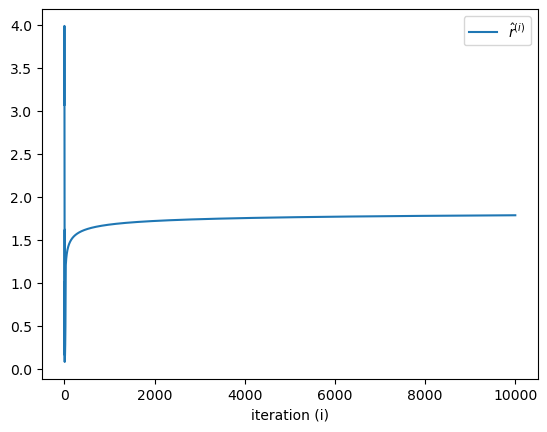

In [31]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

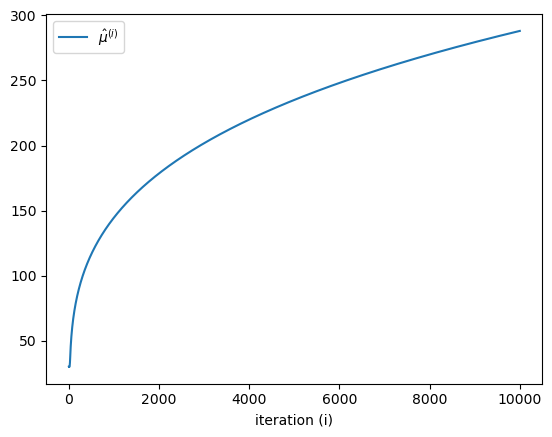

In [32]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

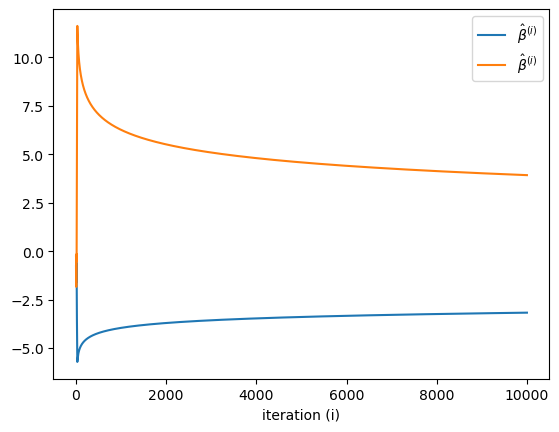

In [33]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [34]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [35]:
for t in np.arange(T+T0):
    o = np.exp(- bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

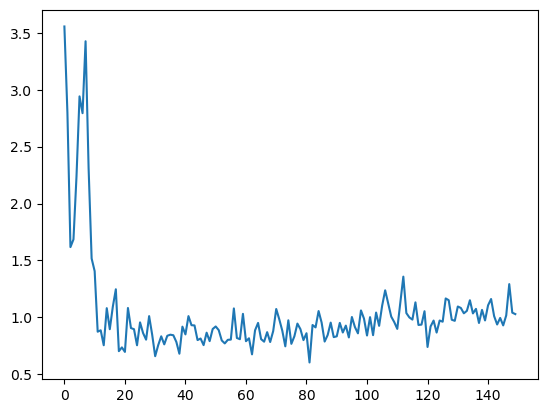

In [36]:
plt.plot(Rmle)

In [37]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [38]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [39]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [40]:
Pi_inv_ImG = Pi @ inv_ImG

In [41]:
EY = mmle_0 * Pi_inv_ImG[:,0]

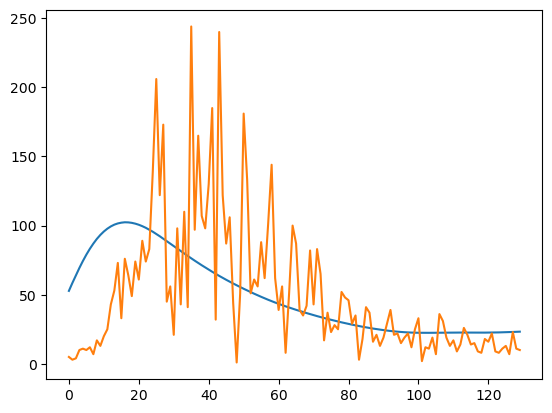

In [42]:
plt.plot(EY)
plt.plot(Y_data)

In [43]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [44]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [45]:
dldEY = Y_data/EY - (rmle+Y_data)/(rmle+EY)
d2ldEY2 = - Y_data/EY**2 + (rmle+Y_data)/(rmle+EY)**2
d2ldrdEY = - 1/(rmle+EY) + (rmle+Y_data)/(rmle+EY)**2

In [46]:
d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y_data, EY)])
d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
       + np.sum(dldEY * d2EY, 2)

d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
        + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

In [47]:
d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                    [d2ldrdm, d2ldm2]])
d2ldrmdb = np.stack([d2ldrdb, 
                     d2ldmdb])

In [48]:
Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                       [d2ldrmdb.T, d2ldb2]])

In [49]:
Ihat_dth

array([[ 1.45046127e+01, -8.38510340e-03, -4.45883046e+00,
        -1.59617332e+00],
       [-8.38510340e-03,  2.76876682e-03,  5.73488969e+00,
         2.16838102e+00],
       [-4.45883046e+00,  5.73488969e+00,  1.49715654e+04,
         5.55553183e+03],
       [-1.59617332e+00,  2.16838102e+00,  5.55553183e+03,
         2.06515647e+03]])

In [50]:
la.inv(Ihat_dth)[2:,2:]

array([[ 0.14983694, -0.43473489],
       [-0.43473489,  1.2640717 ]])

In [51]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

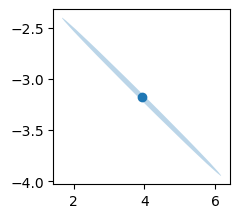

In [55]:
plt.figure(figsize=(5,5))
for i in np.arange(d):
    for j in np.arange(i+1,d):
        plt.subplot(d,d,i*d+j+1)
        p = plt.scatter(bmle[j], bmle[i])
        confidence_ellipse([bmle[j],bmle[i]], np.linalg.pinv(Ihat_dth)[np.ix_([j+2,i+2],[j+2,i+2])], 
                           plt.gca(), facecolor=p.get_facecolor(), alpha=0.3)

In [189]:
def EY_t(beta, mu_0, A):
    assert A.shape[0] > T0
    
    T = A.shape[0]-T0
    R = np.zeros(T+T0)
    for t in np.arange(T+T0):
        o = np.exp(- beta @ A[t])
        p = 1 / (1 + o)
        R[t] = K * p 
        
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    return mu_0 * np.linalg.inv(np.eye(T+T0)-G)[:,0] @ Pi.T

In [200]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [201]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[2:,2:])

In [202]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [203]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

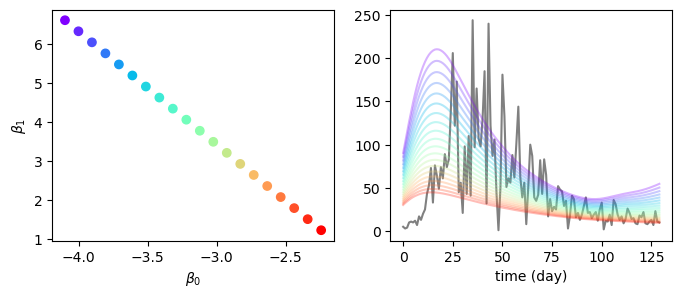

In [204]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 5. Sandwich estimator

In [205]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [206]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [207]:
dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
dltdm = dldEY * Pi_inv_ImG[:,0]
dltdb = dldEY * d1EY

In [208]:
dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)

In [209]:
VEdl = dltdth @ w_HAC @ dltdth.T

In [210]:
VEdl

array([[ 4.67875240e+01,  1.24545656e-01, -6.78958891e+01,
        -1.46746583e+01],
       [ 1.24545656e-01,  5.33404726e-03,  8.01974387e+00,
         3.15719021e+00],
       [-6.78958891e+01,  8.01974387e+00,  1.79304084e+04,
         6.76359490e+03],
       [-1.46746583e+01,  3.15719021e+00,  6.76359490e+03,
         2.56163580e+03]])

In [211]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [212]:
Ihat_sdw

array([[ 9.60483614e+00, -3.44483323e-02,  1.64625279e+01,
         5.85967533e+00],
       [-3.44483323e-02,  2.19818351e-03,  5.18034865e+00,
         1.91043119e+00],
       [ 1.64625279e+01,  5.18034865e+00,  1.44145981e+04,
         5.28559721e+03],
       [ 5.85967533e+00,  1.91043119e+00,  5.28559721e+03,
         1.94002973e+03]])

In [213]:
Ihat_dth

array([[ 1.45046127e+01, -8.38510340e-03, -4.45883046e+00,
        -1.59617332e+00],
       [-8.38510340e-03,  2.76876682e-03,  5.73488969e+00,
         2.16838102e+00],
       [-4.45883046e+00,  5.73488969e+00,  1.49715654e+04,
         5.55553183e+03],
       [-1.59617332e+00,  2.16838102e+00,  5.55553183e+03,
         2.06515647e+03]])

In [214]:
la.inv(Ihat_sdw)[2:,2:]

array([[ 0.09453582, -0.2718768 ],
       [-0.2718768 ,  0.78912415]])

In [215]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [216]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_sdw)[2:,2:])

In [217]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [218]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

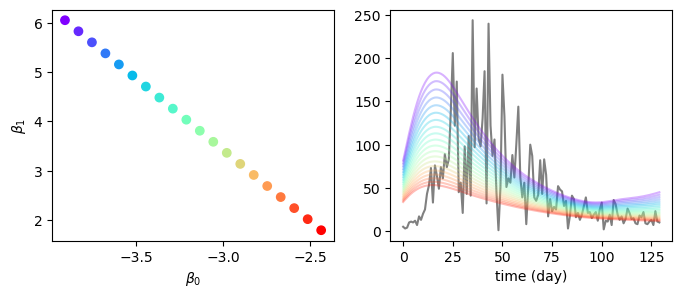

In [219]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 6. Causal forecasting

In [82]:
Tf = 50
Af = np.zeros([Tf, d])

In [169]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [170]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [171]:
# g
ge = np.zeros(Te+T0)
ge[:GPi['g'].shape[0]] = GPi['g']

# pi
pie = np.zeros(Te+T0)
pie[:GPi['pi'].shape[0]] = GPi['pi']

In [172]:
num_sim = 1000

In [173]:
bsim = np.random.multivariate_normal(bmle, la.inv(Ihat_dth)[2:,2:], num_sim)

In [174]:
Rmle = np.zeros(Te+T0)
Rsim = np.zeros([num_sim,Te+T0])

In [175]:
for t in np.arange(Te+T0):
    o = np.exp(- bmle @ Ae[t])
    p = 1 / (1 + o)
    Rmle[t] = K * p
    
    o = np.exp(- bsim @ Ae[t])
    p = 1 / (1 + o)
    Rsim[:,t] = K * p

In [176]:
Pie = alpha * np.concatenate([[0],pie])[np.maximum(0, T0 + np.arange(Te)[:,None] - np.arange(Te+T0))]
Ge = Rmle[:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]
Gesim = Rsim[:,:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]

In [177]:
EYf = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Ge)[:,0] @ Pie.T
EYf_sim = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Gesim)[:,:,0] @ Pie.T

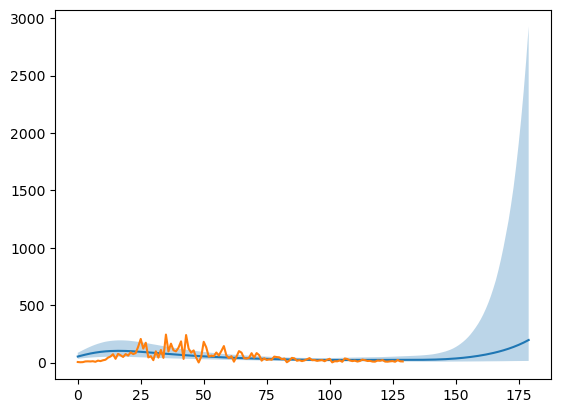

In [180]:
plt.plot(EYf)
plt.fill_between(np.arange(Te), np.quantile(EYf_sim, 0.975, 0), np.quantile(EYf_sim, 0.025, 0),
                 alpha=0.3)
plt.plot(Y_data)

In [ ]:
EY_sim